In [58]:
!ls ../experiments/logs

ar_128		       attn_test3	   new_lr_sweep_nodrop
ar_32		       attn_test_ar_32	   old_ar_32_mamba_ablation
ar_32_1L	       attn_test_ar_32_wd  old_ar_32_mamba_ablation_d_conv
ar_32_3L	       difficulty	   old_ar_32_mamba_ablation_d_conv_2
ar_32_based_ablation   hyena_start	   pcfg_easy
ar_32_based_ablation2  lr_sweep		   pcfg_easy_1L
ar_32_mamba_ablation   lr_sweep_gpt2	   pcfg_easy_8192
ar_32_more_lr	       lr_sweep_llama	   pcfg_easy_nope
ar_32_nope	       misc		   pcfg_medium
arch_easy	       new_lr_sweep	   pcfg_medium_8192
arch_evals	       new_lr_sweep_gpt2   pcfg_medium_nope
arch_sweep	       new_lr_sweep_llama


In [59]:
!ls /nlp/scr/rathi/tinylang_logs/

ar_gen	   multihop    multihop_3  new_gen_1  sibling
gen_sweep  multihop_1  new_gen	   new_gen_3  sibling_3


In [60]:
import glob
import os
import pandas as pd
import plotnine as p9
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mpltern

In [61]:
p9.theme_set(
    p9.theme_bw(base_size=10) +
    p9.theme(
        text=p9.element_text(family="P052", color="#000"),
        figure_size=(2.5, 2.5),
        axis_title=p9.element_text(size=10),
        axis_text=p9.element_text(size=8),
        legend_position="bottom",
        legend_text=p9.element_text(size=8),
        legend_title=p9.element_text(size=9),
        panel_grid_major=p9.element_line(size=0.3, color="#dddddd"),
        panel_grid_minor=p9.element_blank(),
        legend_justification_bottom=1,
        strip_background=p9.element_blank(),
        legend_margin=0,
    )
)

In [62]:
arch_names = {
    "attention": "Attention",
    "based": "Based",
    "base_conv": "BaseConv",
    "h3": "H3",
    "hyena": "Hyena",
    "mamba": "Mamba",
}

In [63]:
def read_df(dirs, filter_steps=5000):
    all_files = []
    for d in dirs:
        all_files.extend(list(glob.glob(d)))
    dfs = []
    for file in tqdm(all_files):
        dirname = os.path.dirname(file)
        evaluator = file.split("/")[-1].split(".")[0]
        split = dirname.split("/")[-1]
        arch, dim, lr = dirname.split("/")[-2].split(".")[0].split("___")
        log = pd.read_csv(file)
        log = log[(log["step"] % filter_steps) == 0]
        log["identifier"] = file
        log["arch"] = arch_names.get(arch, arch)
        log["dim"] = int(dim)
        log["lr"] = float(lr)
        log["evaluator"] = evaluator
        log["step_rel"] = log["step"] / log["step"].max()
        log["layers"] = 2
        log["dataset"] = dirname.split("/")[-3]
        log["split"] = split
        log = log.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset", "split"]).mean().reset_index()
        dfs.append(log)
    print(len(dfs))
    df = pd.concat(dfs)
    df = df.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset", "split"]).mean().reset_index()
    return df

In [72]:
positions = ["target_item_orig", "query_item_orig", "query_item", "divider"]

# get pivoted df
def get_attrib_df(df, df_int, corruption: str="query_item_orig", components: str | list[str]="block_input", prefix="KEY", max_layers=2):
    if isinstance(components, str):
        components = [components]
        
    subset_df = df[(df["variable"].isin(["query_item.argmax", "query_item.pred_prob"])) & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset", "split"]].pivot(index=["dim", "arch", "lr", "dataset", "split"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    
    for component in components:
        for layer in range(max_layers):
            for position in positions:
                metric = f"{layer}.{prefix}.{corruption}.{position}.{component}.restored_prob"
                if metric not in subset_df_int.columns:
                    continue
                corrupted = f"corrupted.{prefix}.{corruption}.{position}.{component}.restored_prob"
                diff = f"{layer}.{prefix}.{corruption}.{position}.{component}.prob_diff"
                original = f"original.{prefix}.{corruption}.{position}.{component}.restored_prob"
                kl_div = f"{layer}.{prefix}.{corruption}.{position}.{component}.kl_div"
                label = f"Association @ {layer}, {position}" if len(components) == 1 else f"Association @ {layer}, {position}, {component}"
                subset_df_int[label] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
                
        for layer in range(max_layers):
            for position in positions:
                metric = f"{layer}.{prefix}.{corruption}.{position}.{component}.restored_prob"
                if metric not in subset_df_int.columns:
                    continue
                corrupted = f"corrupted.{prefix}.{corruption}.{position}.{component}.restored_prob"
                diff = f"{layer}.{prefix}.{corruption}.{position}.{component}.prob_diff"
                original = f"original.{prefix}.{corruption}.{position}.{component}.restored_prob"
                kl_div = f"{layer}.{prefix}.{corruption}.{position}.{component}.kl_div"
                suffix = f"{layer}, {position}" if len(components) == 1 else f"{layer}, {position}, {component}"
                subset_df_int = subset_df_int.rename(columns={
                    metric: f"Restored @ {suffix}",
                    corrupted: f"Corrupted @ {suffix}",
                    diff: f"Diff @ {suffix}",
                    original: f"Original @ {suffix}",
                    kl_div: f"KL @ {suffix}",
                })

    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        "query_item.pred_prob": "Likelihood",
    })

    return subset_df_int

## AR

In [65]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/SummaryEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)
df["arch"] = df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
df["dataset"] = "ar_32"

  3%|▎         | 7/209 [00:00<00:04, 44.74it/s]


KeyboardInterrupt: 

In [9]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

/tmp/user/23259/ipykernel_1474591/2876777681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 6.56 & 100.00 & 100.00 & 100.00 & 100.00 \\
BaseConv & 0.00 & 0.94 & 3.75 & 6.56 & 9.69 \\
Based & 24.38 & 93.12 & 99.06 & 98.75 & 99.06 \\
H3 & 0.94 & 0.62 & 1.88 & 2.50 & 1.56 \\
Hyena & 0.62 & 0.94 & 2.81 & 13.75 & 29.69 \\
Mamba & 10.00 & 76.88 & 80.62 & 89.69 & 91.25 \\
\bottomrule
\end{tabular}



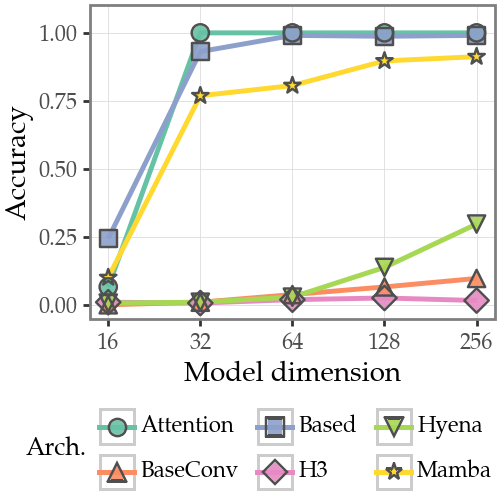

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32.pdf


In [41]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=3, stroke=0, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=3, color="#4f4f4f") +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(2.5, 2.5),
    )
)

plot.show()
plot.save("figs/ar_32.pdf", dpi=300)


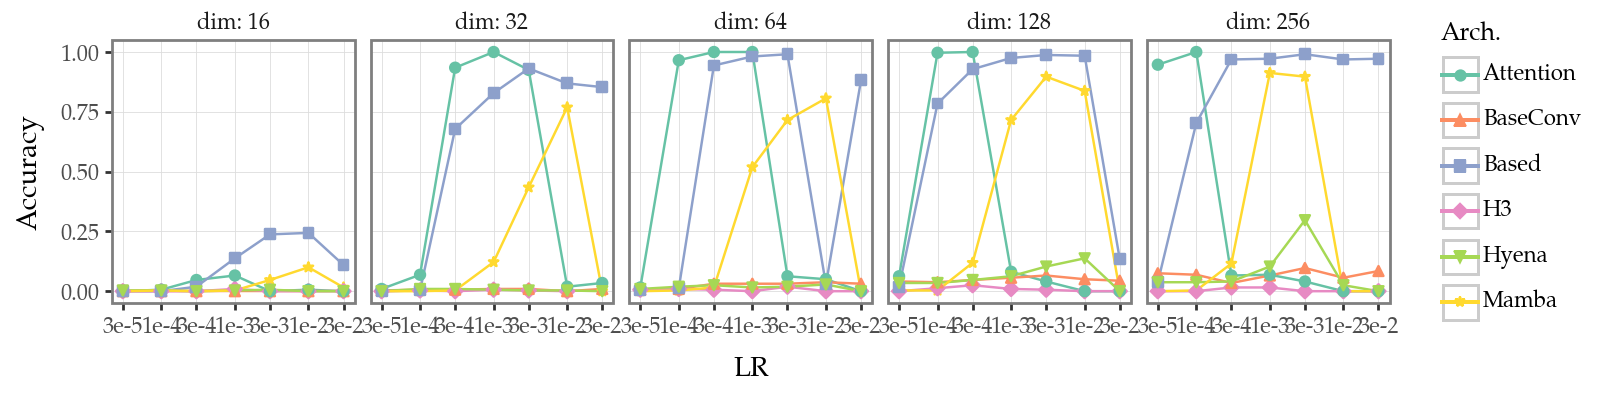

In [91]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_grid("~dim", labeller="label_both") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(8, 2),
        legend_position="right",
    )
)
plot.show()

In [17]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/InterchangeEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)
df_int["arch"] = df_int.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
df_int["dataset"] = "ar_32"

100%|██████████| 208/208 [00:22<00:00,  9.35it/s]


208


In [18]:
subset_df_int = get_attrib_df(df, df_int)
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 220.13 & 100.00 & 100.00 & 100.00 & 100.00 \\
BaseConv & -3.24 & 35.89 & -148.30 & 67.26 & 204.15 \\
Based & 100.26 & 99.91 & 100.00 & 100.00 & 100.07 \\
H3 & -1.50 & -0.64 & 0.08 & 9.09 & 3.61 \\
Hyena & -0.15 & -0.62 & 0.01 & 0.00 & -0.00 \\
Mamba & -0.02 & 0.02 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



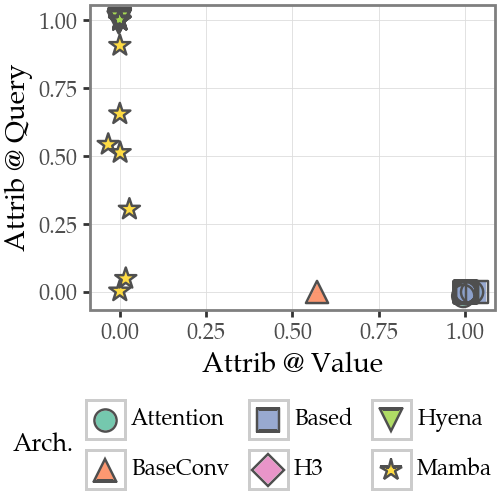

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32_diff_query_item_orig.pdf


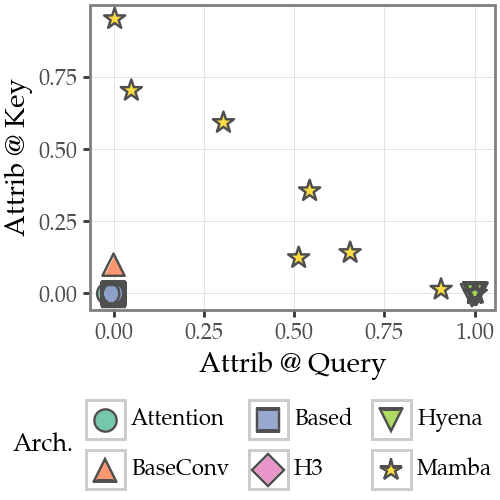

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32_diff_query_item_orig_q.pdf


In [38]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.01]
subset_df_int_plot["arch"] = pd.Categorical(subset_df_int_plot["arch"], categories=list(subset_df_int["arch"].unique()))
subset_df_int_plot["dim"] = pd.Categorical(subset_df_int_plot["dim"], categories=[x for x in sorted(subset_df_int_plot["dim"].unique())], ordered=True)
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch", shape="arch")) +
    p9.geom_point(size=4, stroke=0, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=4, color="#4f4f4f") +
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Value", y="Attrib @ Query") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(2.5, 2.5),
        # axis_text=p9.element_text(size=10),
        # axis_title=p9.element_text(size=12),
        legend_margin=0,
    )
)
plot.show()
plot.save(f"figs/ar_32_diff_query_item_orig.pdf")

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch", shape="arch")) +
    p9.geom_point(size=4, stroke=0, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=4, color="#4f4f4f") +
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Query", y="Attrib @ Key") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(2.5, 2.5),
        # axis_text=p9.element_text(size=10),
        # axis_title=p9.element_text(size=12),
        legend_margin=0,
    )
)
plot.show()
plot.save(f"figs/ar_32_diff_query_item_orig_q.pdf")

## AR Gen

In [132]:
sorted(list(glob.glob("/nlp/scr/rathi/tinylang_logs/ar_gen/**/test/SummaryEvaluator.csv")))

['/nlp/scr/rathi/tinylang_logs/ar_gen/attention___256___1e-04/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___256___3e-02/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___256___3e-03/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___256___3e-04/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___256___3e-05/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___32___1e-02/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___32___1e-03/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___32___1e-04/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___32___3e-02/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___32___3e-03/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi/tinylang_logs/ar_gen/attention___32___3e-04/test/SummaryEvaluator.csv',
 '/nlp/scr/rathi

In [127]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/ar_gen/**/test/SummaryEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/ar_gen/**/dev/SummaryEvaluator.csv",
]
df = read_df(dirs)
df

100%|██████████| 235/235 [00:11<00:00, 20.65it/s]


235


variable    step         evaluator  step_rel  \
0      KEY.query_item.argmax       0  SummaryEvaluator       0.0   
1      KEY.query_item.argmax       0  SummaryEvaluator       0.0   
2      KEY.query_item.argmax       0  SummaryEvaluator       0.0   
3      KEY.query_item.argmax       0  SummaryEvaluator       0.0   
4      KEY.query_item.argmax       0  SummaryEvaluator       0.0   
...                      ...     ...               ...       ...   
24670   query_item.pred_prob  100000  SummaryEvaluator       1.0   
24671   query_item.pred_prob  100000  SummaryEvaluator       1.0   
24672   query_item.pred_prob  100000  SummaryEvaluator       1.0   
24673   query_item.pred_prob  100000  SummaryEvaluator       1.0   
24674   query_item.pred_prob  100000  SummaryEvaluator       1.0   

                                              identifier       arch  dim  \
0      /nlp/scr/rathi/tinylang_logs/ar_gen/attention_...  Attention  256   
1      /nlp/scr/rathi/tinylang_logs/ar_gen/attention_...  Attention  256   
2      /nlp/scr/rathi/tinylang_logs/ar_gen/attention_...  Attention  256   
3      /nlp/scr/rathi/tinylang_logs/ar_gen/attention_...  Attention  256   
4      /nlp/scr/rathi/tinylang_logs/ar_gen/attention_...  Attention  256   
...                                                  ...        ...  ...   
24670  /nlp/scr/rathi/tinylang_logs/ar_gen/mamba___16...      Mamba   16   
24671  /nlp/scr/rathi/tinylang_logs/ar_gen/mamba___16...      Mamba   16   
24672  /nlp/scr/rathi/tinylang_logs/ar_gen/mamba___25...      Mamba  256   
24673  /nlp/scr/rathi/tinylang_logs/ar_gen/mamba___25...      Mamba  256   
24674  /nlp/scr/rathi/tinylang_logs/ar_gen/mamba___25...      Mamba  256   

            lr  layers dataset split     value  
0      0.00010       2  ar_gen   dev  0.000000  
1      0.00010       2  ar_gen  test  0.000000  
2      0.03000       2  ar_gen   dev  0.000000  
3      0.03000       2  ar_gen  test  0.000000  
4      0.00300       2  ar_gen   dev  0.000000  
...        ...     ...     ...   ...       ...  
24670  0.00003       2  ar_gen   dev  0.000237  
24671  0.00003       2  ar_gen  test  0.000254  
24672  0.01000       2  ar_gen   dev  0.932097  
24673  0.01000       2  ar_gen  test  0.947379  
24674  0.00100       2  ar_gen   dev  0.934987  

[24675 rows x 12 columns]

In [128]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df.copy().reset_index().pivot(index=["arch", "dim", "lr", "dataset"], columns="split", values="value").reset_index()
subset_df_best = subset_df_best[["dim", "arch", "dev", "test", "dataset"]]
subset_df_best = subset_df_best.iloc[subset_df_best.groupby(["dim", "arch", "dataset"])["dev"].idxmax()].reset_index()

pivoted = subset_df_best.copy()
pivoted["dev"] = pivoted["dev"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted["test"] = pivoted["test"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.melt(id_vars=["dim", "arch", "dataset", "index"])[["dim", "arch", "dataset", "split", "value"]]
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "split", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{value} \\
dataset & \multicolumn{10}{r}{ar_gen} \\
split & \multicolumn{5}{r}{dev} & \multicolumn{5}{r}{test} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & NaN & 100.00 & 100.00 & NaN & 100.00 & NaN & 100.00 & 100.00 & NaN & 100.00 \\
BaseConv & 1.25 & NaN & NaN & 6.25 & NaN & 0.00 & NaN & NaN & 5.62 & NaN \\
Based & NaN & 67.81 & 98.44 & NaN & NaN & NaN & 68.44 & 98.75 & NaN & NaN \\
H3 & 0.94 & 0.94 & 3.44 & 0.62 & 3.75 & 0.00 & 0.31 & 2.19 & 0.31 & 3.12 \\
Hyena & 0.31 & 2.19 & 3.44 & 8.12 & 22.19 & 0.31 & 1.25 & 1.88 & 7.81 & 30.00 \\
Mamba & 15.31 & NaN & NaN & 90.62 & 94.38 & 10.31 & NaN & NaN & 90.94 & nan \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1553253/3747605971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [130]:
subset_df_best

split  index  dim       arch       dev      test dataset
0         21   16   BaseConv  0.012500  0.000000  ar_gen
1         44   16         H3  0.009375  0.000000  ar_gen
2         77   16      Hyena  0.003125  0.003125  ar_gen
3        108   16      Mamba  0.153125  0.103125  ar_gen
4          3   32  Attention  1.000000  1.000000  ar_gen
5         33   32      Based  0.678125  0.684375  ar_gen
6         50   32         H3  0.009375  0.003125  ar_gen
7         83   32      Hyena  0.021875  0.012500  ar_gen
8          9   64  Attention  1.000000  1.000000  ar_gen
9         37   64      Based  0.984375  0.987500  ar_gen
10        58   64         H3  0.034375  0.021875  ar_gen
11        89   64      Hyena  0.034375  0.018750  ar_gen
12        28  128   BaseConv  0.062500  0.056250  ar_gen
13        64  128         H3  0.006250  0.003125  ar_gen
14        94  128      Hyena  0.081250  0.078125  ar_gen
15       114  128      Mamba  0.906250  0.909375  ar_gen
16        15  256  Attention  1.000000  1.000000  ar_gen
17        71  256         H3  0.037500  0.031250  ar_gen
18       102  256      Hyena  0.221875  0.300000  ar_gen
19       116  256      Mamba  0.943750       NaN  ar_gen

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


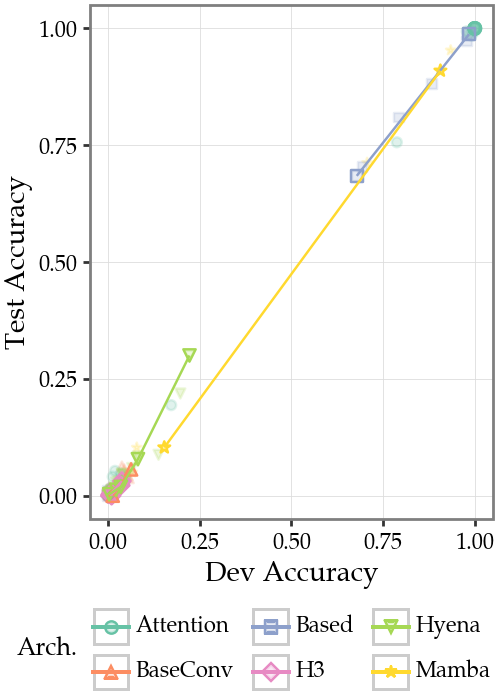

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_gen_dev_test.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


In [129]:
dev_test_combined = subset_df.copy()
dev_test_combined_best = subset_df_best.copy()
dev_test_combined = dev_test_combined.pivot(index=["arch", "dim", "dataset", "lr"], columns="split", values="value").reset_index()
plot = (
    p9.ggplot(dev_test_combined, p9.aes(x="dev", y="test", color="arch", group="arch", shape="arch")) +
    # p9.facet_wrap("~dim") +
    # p9.geom_path() +
    p9.geom_point(alpha=0.2, stroke=0.5) +
    p9.geom_point(dev_test_combined_best, fill="none", stroke=0.5, size=2) +
    # p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(x="Dev Accuracy", y="Test Accuracy", color="Arch.", shape="Arch.") +
    # p9.geom_text(dev_test_combined[dev_test_combined["dim"].isin([16, 256])], p9.aes(label="dim"), size=6, nudge_y=0.03) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.geom_path(dev_test_combined_best) +
    p9.theme(
        figure_size=(2.5, 3.5)
    )
    # p9.xlim(0.7, 1) +
    # p9.ylim(0, 1)
)
plot.show()
plot.save("figs/ar_gen_dev_test.pdf")

## AR multilayer

In [143]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/SummaryEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_1L/**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_3L/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)
df

100%|██████████| 593/593 [00:27<00:00, 21.60it/s]


593


variable   step         evaluator  step_rel  \
0      KEY.query_item.argmax      0  SummaryEvaluator       0.0   
1      KEY.query_item.argmax      0  SummaryEvaluator       0.0   
2      KEY.query_item.argmax      0  SummaryEvaluator       0.0   
3      KEY.query_item.argmax      0  SummaryEvaluator       0.0   
4      KEY.query_item.argmax      0  SummaryEvaluator       0.0   
...                      ...    ...               ...       ...   
32610   query_item.pred_prob  50000  SummaryEvaluator       1.0   
32611   query_item.pred_prob  50000  SummaryEvaluator       1.0   
32612   query_item.pred_prob  50000  SummaryEvaluator       1.0   
32613   query_item.pred_prob  50000  SummaryEvaluator       1.0   
32614   query_item.pred_prob  50000  SummaryEvaluator       1.0   

                                              identifier       arch  dim  \
0      ../experiments/logs/ar_32/attention___128___1e...  Attention  128   
1      ../experiments/logs/ar_32/attention___128___1e...  Attention  128   
2      ../experiments/logs/ar_32/attention___128___3e...  Attention  128   
3      ../experiments/logs/ar_32/attention___128___3e...  Attention  128   
4      ../experiments/logs/ar_32/attention___128___3e...  Attention  128   
...                                                  ...        ...  ...   
32610  ../experiments/logs/ar_32_nope/mamba___64___1e...      Mamba   64   
32611  ../experiments/logs/ar_32_nope/mamba___64___1e...      Mamba   64   
32612  ../experiments/logs/ar_32_nope/mamba___64___3e...      Mamba   64   
32613  ../experiments/logs/ar_32_nope/mamba___64___3e...      Mamba   64   
32614  ../experiments/logs/ar_32_nope/mamba___64___3e...      Mamba   64   

            lr  layers     dataset split     value  
0      0.00100       2       ar_32  test  0.000000  
1      0.00010       2       ar_32  test  0.000000  
2      0.00300       2       ar_32  test  0.000000  
3      0.00030       2       ar_32  test  0.000000  
4      0.00003       2       ar_32  test  0.000000  
...        ...     ...         ...   ...       ...  
32610  0.00100       2  ar_32_nope  test  0.492791  
32611  0.00010       2  ar_32_nope  test  0.000316  
32612  0.00300       2  ar_32_nope  test  0.703496  
32613  0.00030       2  ar_32_nope  test  0.005859  
32614  0.00003       2  ar_32_nope  test  0.000214  

[32615 rows x 12 columns]

In [144]:
df["dataset"] = df["dataset"].map({
    "ar_32": "2-layer",
    "ar_32_nope": "2-layer",
    "ar_32_more_lr": "2-layer",
    "ar_32_1L": "1-layer",
    "ar_32_3L": "3-layer",
})

In [145]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{value} \\
dataset & \multicolumn{5}{r}{1-layer} & \multicolumn{5}{r}{2-layer} & \multicolumn{5}{r}{3-layer} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 1.25 & 6.56 & 9.06 & 8.44 & 6.25 & 6.56 & 100.00 & 100.00 & 100.00 & 100.00 & 13.12 & 99.69 & 100.00 & 100.00 & 100.00 \\
BaseConv & 2.50 & 2.50 & 2.81 & 2.50 & 1.88 & 0.00 & 0.94 & 3.75 & 6.56 & 9.69 & 0.31 & 2.19 & 3.12 & 7.50 & 8.12 \\
Based & NaN & NaN & NaN & NaN & NaN & 24.38 & 93.12 & 99.06 & 98.75 & 99.06 & 37.50 & 90.94 & 99.06 & 98.75 & 99.38 \\
H3 & 0.62 & 1.88 & 2.50 & 2.81 & 3.12 & 0.94 & 0.62 & 1.88 & 2.50 & 1.56 & 0.94 & 1.25 & 1.25 & 1.56 & 1.88 \\
Hyena & 0.31 & 1.25 & 2.19 & 7.81 & 31.56 & 0.62 & 0.94 & 2.81 & 13.75 & 29.69 & 0.62 & 1.25 & 3.44 & 8.44 & 20.00 \\
Mamba & 10.62 & 47.19 & 83.12 & 86.88 & 96.25 & 10.00 & 76.88 & 80.62 & 89

/tmp/user/23259/ipykernel_1553253/2876777681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


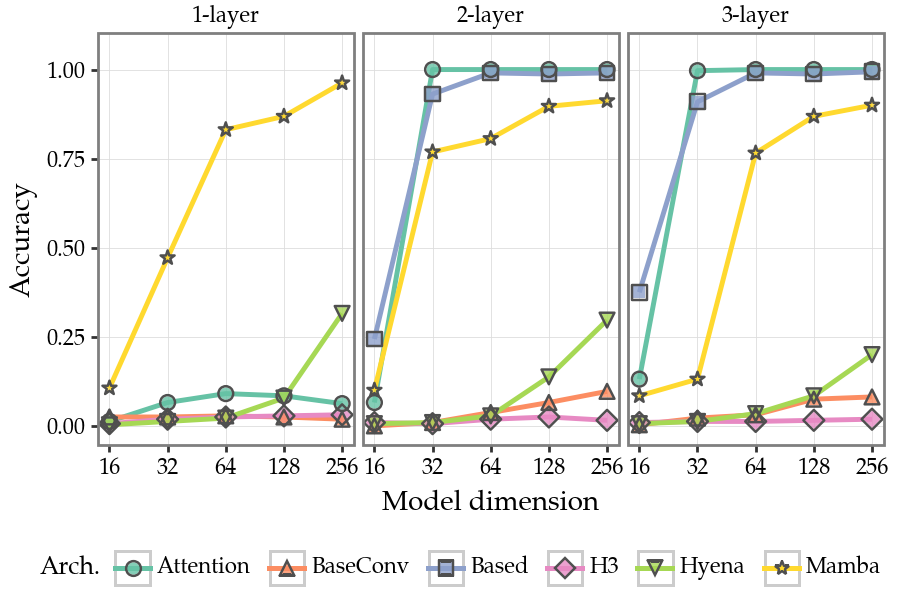

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32_layers_with_3.pdf


In [56]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, stroke=0, alpha=0.8) +
    p9.geom_point(fill="none", stroke=0.5, size=2.5, color="#4f4f4f") +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(4.5, 3),
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)

plot.show()
plot.save("figs/ar_32_layers_with_3.pdf", dpi=300)


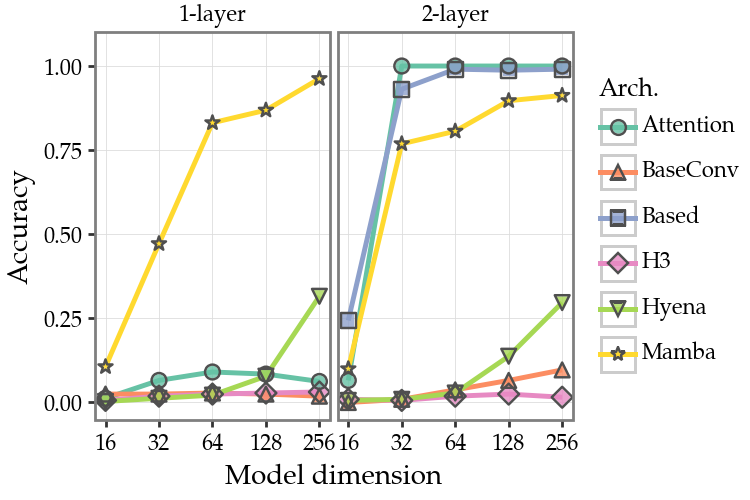

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.75 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32_layers.pdf


In [123]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, stroke=0, alpha=0.8) +
    p9.geom_point(fill="none", stroke=0.5, size=2.5, color="#4f4f4f") +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(3.75, 2.5),
        legend_position="right",
    )
)

plot.show()
plot.save("figs/ar_32_layers.pdf", dpi=300)


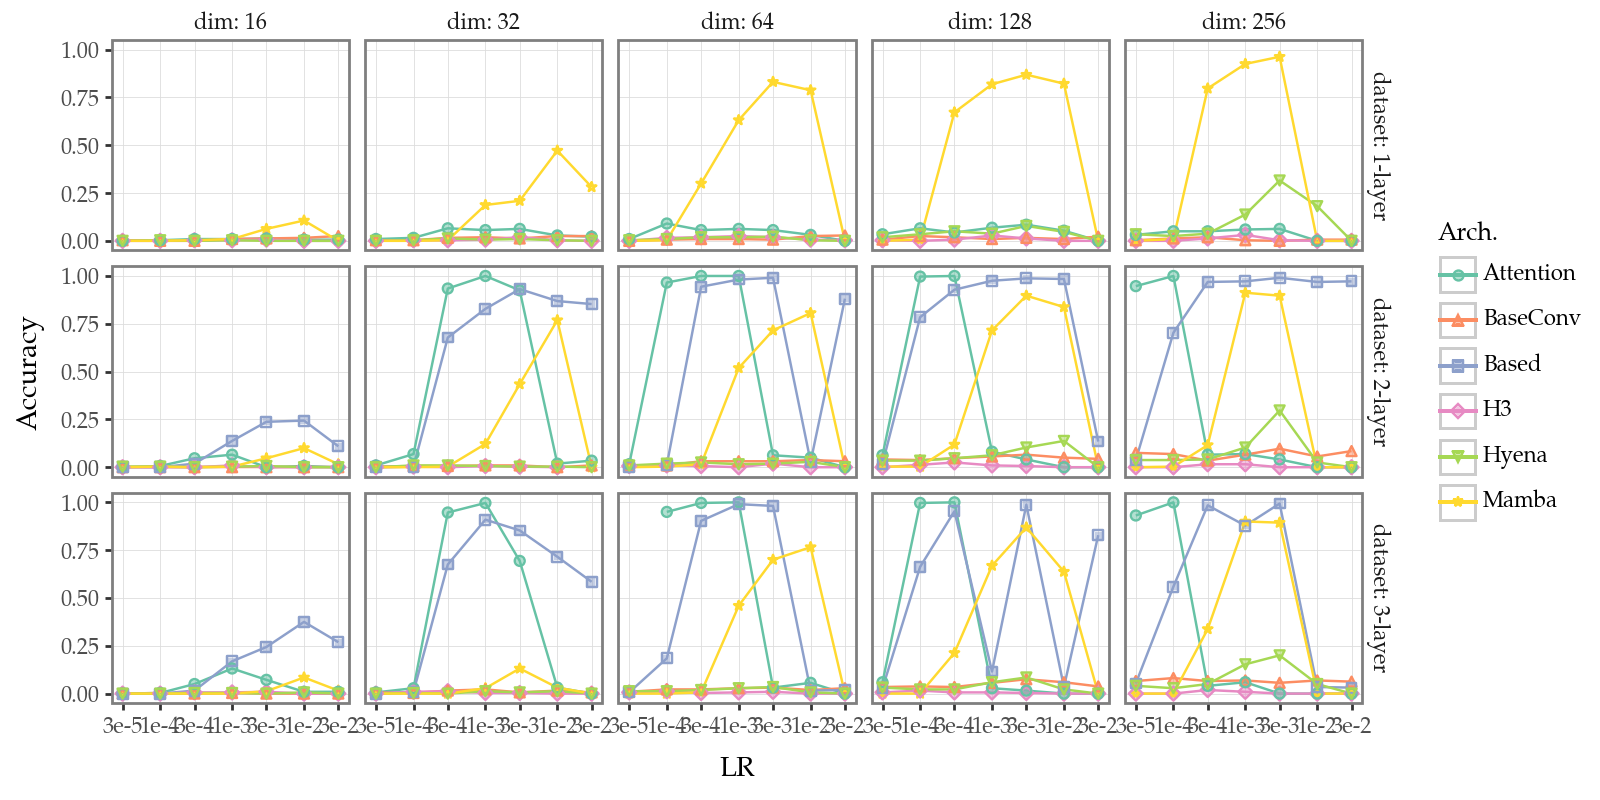

In [81]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point(stroke=0, alpha=0.5) +
    p9.geom_point(fill="none", stroke=0.5) +
    p9.facet_grid("dataset~dim", labeller="label_both") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(8, 4),
        legend_position="right",
    )
)
plot.show()

In [146]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/InterchangeEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_1L/**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_3L/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)
df_int

100%|██████████| 592/592 [01:10<00:00,  8.36it/s]


592


variable   step  \
0        0.KEY.query_item_orig.divider.attention_input....      0   
1        0.KEY.query_item_orig.divider.attention_input....      0   
2        0.KEY.query_item_orig.divider.attention_input....      0   
3        0.KEY.query_item_orig.divider.attention_input....      0   
4        0.KEY.query_item_orig.divider.attention_input....      0   
...                                                    ...    ...   
7293391  original.KEY.target_item_orig.target_item_orig...  50000   
7293392  original.KEY.target_item_orig.target_item_orig...  50000   
7293393  original.KEY.target_item_orig.target_item_orig...  50000   
7293394  original.KEY.target_item_orig.target_item_orig...  50000   
7293395  original.KEY.target_item_orig.target_item_orig...  50000   

                    evaluator  step_rel  \
0        InterchangeEvaluator       0.0   
1        InterchangeEvaluator       0.0   
2        InterchangeEvaluator       0.0   
3        InterchangeEvaluator       0.0   
4        InterchangeEvaluator       0.0   
...                       ...       ...   
7293391  InterchangeEvaluator       1.0   
7293392  InterchangeEvaluator       1.0   
7293393  InterchangeEvaluator       1.0   
7293394  InterchangeEvaluator       1.0   
7293395  InterchangeEvaluator       1.0   

                                                identifier       arch  dim  \
0        ../experiments/logs/ar_32/attention___128___1e...  Attention  128   
1        ../experiments/logs/ar_32/attention___128___1e...  Attention  128   
2        ../experiments/logs/ar_32/attention___128___3e...  Attention  128   
3        ../experiments/logs/ar_32/attention___128___3e...  Attention  128   
4        ../experiments/logs/ar_32/attention___128___3e...  Attention  128   
...                                                    ...        ...  ...   
7293391  ../experiments/logs/ar_32_nope/hyena___64___1e...      Hyena   64   
7293392  ../experiments/logs/ar_32_nope/hyena___64___1e...      Hyena   64   
7293393  ../experiments/logs/ar_32_nope/hyena___64___3e...      Hyena   64   
7293394  ../experiments/logs/ar_32_nope/hyena___64___3e...      Hyena   64   
7293395  ../experiments/logs/ar_32_nope/hyena___64___3e...      Hyena   64   

              lr  layers     dataset split     value  
0        0.00100       2       ar_32  test  0.000000  
1        0.00010       2       ar_32  test  0.000000  
2        0.00300       2       ar_32  test  0.000000  
3        0.00030       2       ar_32  test  0.000000  
4        0.00003       2       ar_32  test  0.000000  
...          ...     ...         ...   ...       ...  
7293391  0.00100       2  ar_32_nope  test  0.016915  
7293392  0.00010       2  ar_32_nope  test  0.002224  
7293393  0.00300       2  ar_32_nope  test  0.019438  
7293394  0.00030       2  ar_32_nope  test  0.014723  
7293395  0.00003       2  ar_32_nope  test  0.000376  

[7293396 rows x 12 columns]

In [147]:
df_int["variable"] = df_int["variable"].apply(lambda x: x.replace("PARENT", "KEY"))
df_int["dataset"] = df_int["dataset"].map({
    "ar_32": "2-layer",
    "ar_32_nope": "2-layer",
    "ar_32_more_lr": "2-layer",
    "ar_32_1L": "1-layer",
    "ar_32_3L": "3-layer",
})

In [148]:
subset_df_int = get_attrib_df(df, df_int, components="mlp_output", max_layers=3)
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, query_item"]]
pivoted["Association @ 1, query_item"] = pivoted["Association @ 1, query_item"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{Association @ 1, query_item} \\
dataset & \multicolumn{5}{r}{1-layer} & \multicolumn{5}{r}{2-layer} & \multicolumn{5}{r}{3-layer} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & nan & nan & nan & nan & nan & 7.09 & 0.31 & 2.33 & 5.80 & 77.42 & 0.99 & 0.28 & 0.05 & 1.35 & 9.04 \\
BaseConv & nan & nan & nan & nan & nan & 0.02 & -3.83 & 1.97 & -1.43 & 1.16 & -1.70 & -0.99 & -360.70 & 2.48 & -19.27 \\
Based & NaN & NaN & NaN & NaN & NaN & -0.13 & 0.01 & -0.05 & -0.01 & 0.00 & -0.15 & 0.07 & -0.03 & 0.01 & -0.00 \\
H3 & nan & nan & nan & nan & nan & 1.04 & 0.54 & -0.00 & 6.90 & -0.07 & -0.53 & 1.55 & -2.50 & 9.04 & -0.48 \\
Hyena & nan & nan & nan & nan & nan & -0.05 & -0.03 & 0.00 & 0.00 & -0.00 & -0.00 & -0.91 & -0.00 & -0.00 & -0.00 \\
Mamba & nan & nan & nan & nan & nan & nan & nan & nan & nan & nan & nan &

In [149]:
# which_layer_df = subset_df_int.copy()
position = "query_item"
which_layer_df = subset_df_int[subset_df_int[f"Original @ 0, {position}"] - subset_df_int[f"Corrupted @ 0, {position}"] > 0.01].copy()
which_layer_df = which_layer_df[["dim", "arch", "lr", "dataset", f"Association @ 0, {position}", f"Association @ 1, {position}", f"Association @ 2, {position}"]]
which_layer_df = which_layer_df.melt(id_vars=["dim", "arch", "lr", "dataset"]).dropna()
which_layer_df["layer"] = which_layer_df["variable"].map({
    "Association @ 0, query_item": "Layer 0",
    "Association @ 1, query_item": "Layer 1",
    "Association @ 2, query_item": "Layer 2"
})
which_layer_df

dim       arch      lr  dataset                     variable  \
0     16  Attention  0.0010  3-layer  Association @ 0, query_item   
1     16      Based  0.0010  2-layer  Association @ 0, query_item   
2     16      Based  0.0010  3-layer  Association @ 0, query_item   
3     16      Based  0.0030  2-layer  Association @ 0, query_item   
4     16      Based  0.0030  3-layer  Association @ 0, query_item   
..   ...        ...     ...      ...                          ...   
279  256      Based  0.0030  3-layer  Association @ 2, query_item   
284  256      Hyena  0.0003  3-layer  Association @ 2, query_item   
287  256      Hyena  0.0010  3-layer  Association @ 2, query_item   
290  256      Hyena  0.0030  3-layer  Association @ 2, query_item   
293  256      Hyena  0.0100  3-layer  Association @ 2, query_item   

            value    layer  
0    4.532126e-05  Layer 0  
1    0.000000e+00  Layer 0  
2    0.000000e+00  Layer 0  
3    0.000000e+00  Layer 0  
4    0.000000e+00  Layer 0  
..            ...      ...  
279 -9.059941e-05  Layer 2  
284  8.488670e-03  Layer 2  
287  1.646669e-08  Layer 2  
290  4.572333e-09  Layer 2  
293  0.000000e+00  Layer 2  

[227 rows x 7 columns]

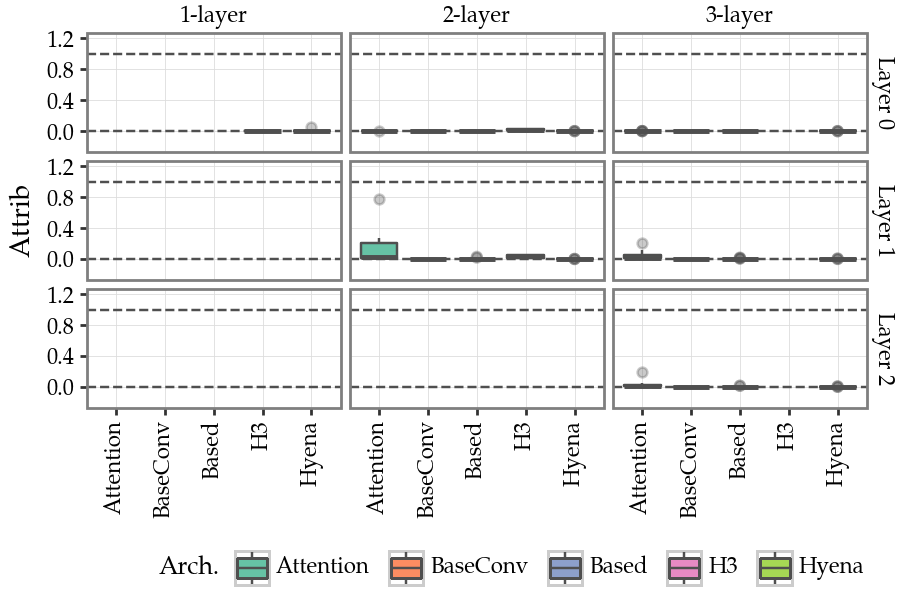

In [150]:
subset_df_int_plot = which_layer_df.copy()
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="value", fill="arch", group="arch")) +
    p9.facet_grid("layer~dataset") +
    p9.geom_boxplot(outlier_alpha=0.3, color="#4f4f4f") +
    p9.labs(y="Attrib", x="Arch.", fill="Arch.") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_fill_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
        axis_text_x=p9.element_text(angle=90, hjust=0.5),
        axis_title_x=p9.element_blank(),
    ) +
    p9.guides(
        fill=p9.guide_legend(
            nrow=1
        )
    ) +
    p9.geom_hline(yintercept=0, color="#4f4f4f", linetype="dashed") +
    p9.geom_hline(yintercept=1, color="#4f4f4f", linetype="dashed") +
    p9.ylim(-0.2, 1.2)
)
plot.show()
# plot.save("figs/ar_32_layers_attrib.pdf", dpi=300)

## Benchmarking ATR, varying $L$

In [22]:
dirs = [
    "../experiments/logs/pcfg_easy/attention**/test/SummaryEvaluator.csv",
    # "../experiments/logs/pcfg_easy_nope/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_8192/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)

100%|██████████| 423/423 [01:08<00:00,  6.15it/s]


423


In [23]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["arch"] = subset_df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{value} \\
dataset & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_easy_8192} & \multicolumn{5}{r}{pcfg_medium} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 68.44 & 90.31 & 93.75 & 95.31 & 96.25 & 72.50 & 84.06 & 89.38 & 86.88 & 86.56 & 50.94 & 56.88 & 75.62 & 80.62 & 80.94 \\
BaseConv & 67.50 & 75.62 & 82.50 & 86.88 & 90.00 & 42.50 & 46.56 & 55.94 & 59.69 & 66.25 & 55.94 & 61.56 & 65.31 & 70.62 & 68.75 \\
Based & 82.19 & 91.25 & 91.88 & 93.12 & 92.19 & 68.44 & 83.12 & 86.56 & 87.50 & 86.56 & 63.12 & 71.56 & 70.00 & 70.94 & 73.12 \\
H3 & 81.88 & 87.81 & 90.00 & 94.06 & 94.06 & 49.38 & 63.44 & 72.50 & 75.94 & 76.25 & NaN & NaN & NaN & NaN & NaN \\
Hyena & 75.94 & 80.94 & 85.31 & 92.50 & 93.75 & 45.94 & 57.81 & 64.69 & 69.06 & 70.00 & 57.81 & 63.75 & 62.50 & 66.25 & 68.44 \\
Mamba & 91.25 & 94.38

/tmp/user/23259/ipykernel_1530035/765897195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/user/23259/ipykernel_1530035/765897195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


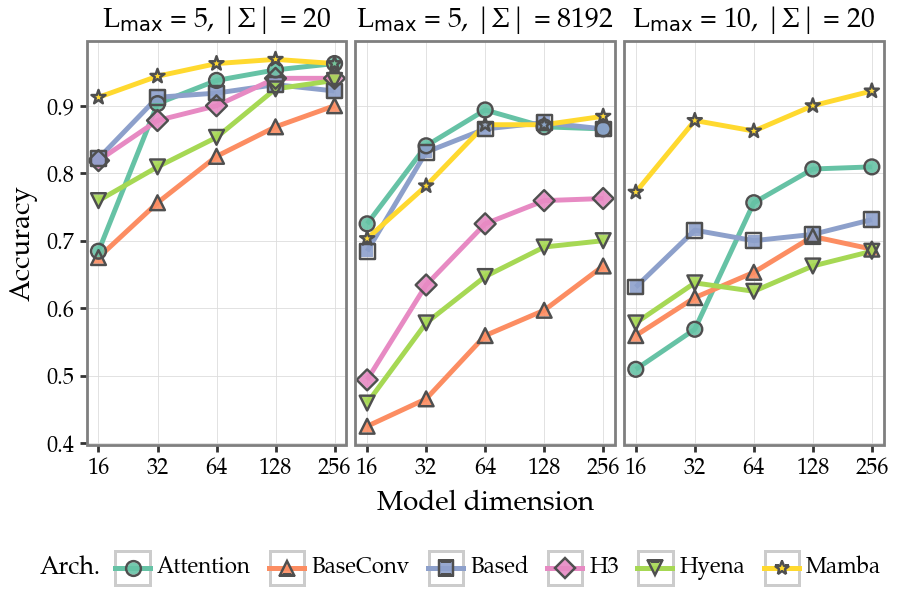

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr.pdf


In [28]:
subset_df_plot = subset_df.copy()
subset_df_plot["dataset"] = subset_df_plot["dataset"].map({
    "pcfg_easy": "L$_\mathrm{max}$ = 5, |Σ| = 20",
    "pcfg_easy_8192": "L$_\mathrm{max}$ = 5, |Σ| = 8192",
    "pcfg_medium": "L$_\mathrm{max}$ = 10, |Σ| = 20"
})
subset_df_plot["dataset"] = pd.Categorical(subset_df_plot["dataset"], categories=["L$_\mathrm{max}$ = 5, |Σ| = 20", "L$_\mathrm{max}$ = 5, |Σ| = 8192", "L$_\mathrm{max}$ = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_plot, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(stroke=0, size=2.5, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=2.5, color="#4f4f4f") +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    # p9.ylim(0, 1.05) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
        strip_text_x=p9.element_text(size=10),
        axis_title=p9.element_text(size=10),
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/atr.pdf")

In [29]:
dirs = [
    "../experiments/logs/pcfg_easy/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_8192/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)

100%|██████████| 423/423 [02:39<00:00,  2.66it/s]


423


In [30]:
subset_df_int = get_attrib_df(df, df_int, corruption="query_item_orig", components="block_input", prefix="PARENT").reset_index()
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_easy_8192} & \multicolumn{5}{r}{pcfg_medium} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 23.09 & 109.29 & 102.24 & 107.19 & 102.69 & 93.81 & 90.00 & 99.23 & 86.36 & 84.77 & 11.55 & -23.18 & 112.20 & 117.13 & 109.59 \\
BaseConv & 39.82 & 27.36 & 51.08 & 69.12 & 68.92 & -2.83 & 18.92 & 20.37 & 28.35 & 61.02 & 49.96 & 49.33 & 52.78 & 59.49 & 77.11 \\
Based & 13.37 & 93.63 & 95.11 & 87.47 & 86.47 & 74.49 & 85.10 & 93.31 & 96.87 & 101.90 & 87.30 & 87.33 & 58.68 & 86.25 & 82.57 \\
H3 & 0.83 & 8.64 & 7.16 & 2.66 & 1.53 & -1.05 & 3.34 & 5.68 & -0.08 & -0.92 & NaN & NaN & NaN & NaN & NaN \\
Hyena & 4.97 & 11.95 & 11.46 & 0.09 & 6.77 & 23.32 & 1.20 & 7.97 & 5.70 & 0.73 & 17.33 & 3.67 & 14.48 & 5.42 & 9.01 \\
M

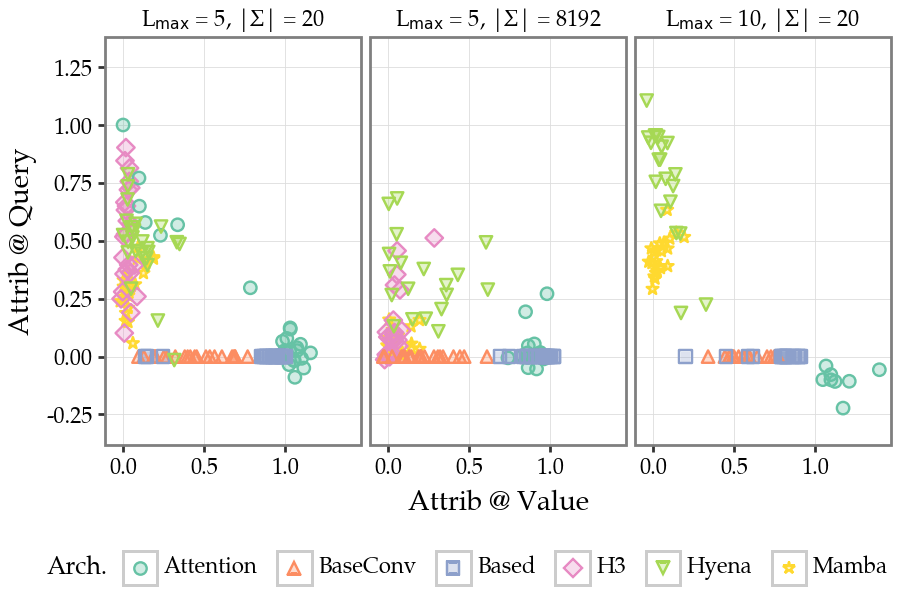

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_diff.pdf


In [31]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.1]
subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
    "pcfg_easy": "L$_\mathrm{max}$ = 5, |Σ| = 20",
    "pcfg_easy_8192": "L$_\mathrm{max}$ = 5, |Σ| = 8192",
    "pcfg_medium": "L$_\mathrm{max}$ = 10, |Σ| = 20"
})
subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["L$_\mathrm{max}$ = 5, |Σ| = 20", "L$_\mathrm{max}$ = 5, |Σ| = 8192", "L$_\mathrm{max}$ = 10, |Σ| = 20"], ordered=True)

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(x="Attrib @ Value", y="Attrib @ Query", color="Arch.", shape="Arch.") +
    # p9.scale_x_log10() +
    p9.scale_y_continuous(limits=(-0.3, 1.3), breaks=[-0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25]) +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/atr_diff.pdf")

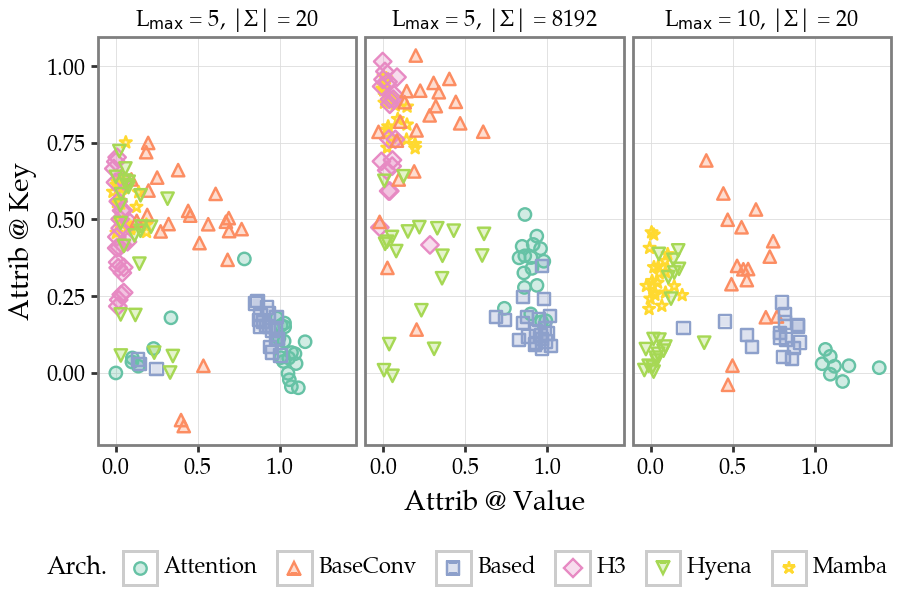

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_diff_k.pdf


In [32]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item_orig", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Value", y="Attrib @ Key") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/atr_diff_k.pdf")

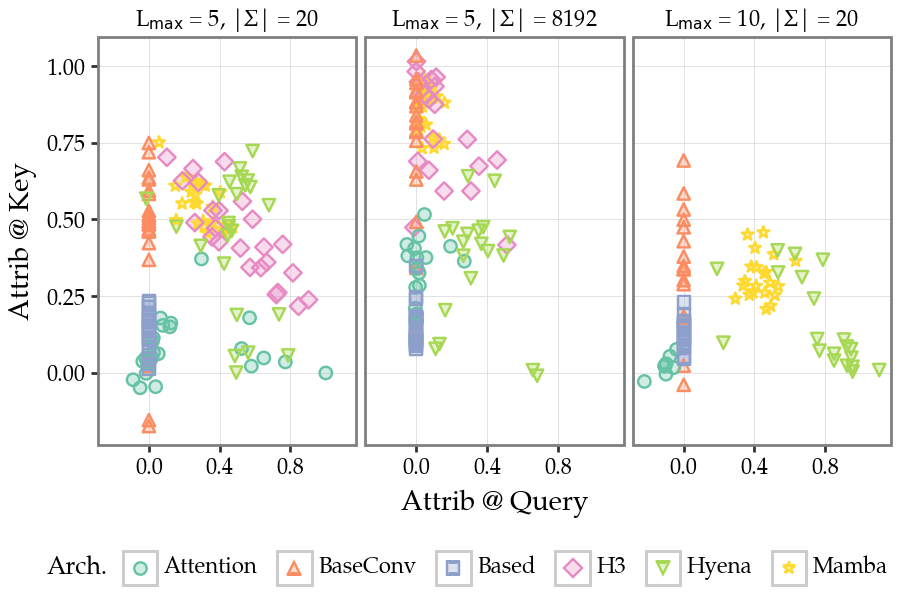

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_diff_q.pdf


In [33]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Query", y="Attrib @ Key") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/atr_diff_q.pdf")

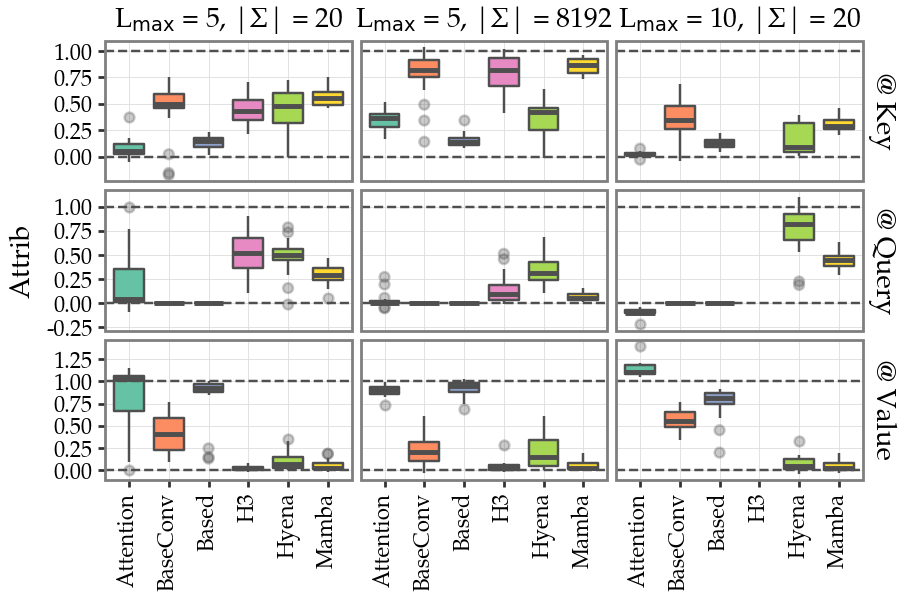

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_box.pdf


In [34]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.1]
subset_df_int_plot = subset_df_int_plot[["dim", "arch", "dataset", "Association @ 1, query_item", "Association @ 1, query_item_orig", "Association @ 1, target_item_orig"]]
subset_df_int_plot = subset_df_int_plot.melt(id_vars=["dim", "arch", "dataset"])
subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
    "pcfg_easy": "L$_\mathrm{max}$ = 5, |Σ| = 20",
    "pcfg_easy_8192": "L$_\mathrm{max}$ = 5, |Σ| = 8192",
    "pcfg_medium": "L$_\mathrm{max}$ = 10, |Σ| = 20"
})
subset_df_int_plot["variable"] = subset_df_int_plot["variable"].map({
    "Association @ 1, query_item": "@ Query",
    "Association @ 1, query_item_orig": "@ Key",
    "Association @ 1, target_item_orig": "@ Value"
})
subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["L$_\mathrm{max}$ = 5, |Σ| = 20", "L$_\mathrm{max}$ = 5, |Σ| = 8192", "L$_\mathrm{max}$ = 10, |Σ| = 20"], ordered=True)
subset_df_int_plot

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="value", fill="arch", group="arch", shape="arch")) +
    p9.facet_grid("variable ~ dataset", scales="free_y") +
    p9.scale_y_continuous(breaks=[-0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25]) +
    p9.geom_boxplot(outlier_alpha=0.3, color="#4f4f4f") +
    p9.labs(y="Attrib") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_fill_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="none",
        legend_justification_bottom=1,
        axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=1),
        axis_title_x=p9.element_blank(),
        strip_text=p9.element_text(size=10),
        axis_title=p9.element_text(size=10),
    ) +
    p9.guides(
        fill=p9.guide_legend(
            nrow=1
        )
    ) +
    p9.geom_hline(yintercept=1, linetype="dashed", color="#4f4f4f") +
    p9.geom_hline(yintercept=0, linetype="dashed", color="#4f4f4f")
)
plot.show()
plot.save("figs/atr_box.pdf")

['Association @ 0, target_item_orig, attention_input', 'Association @ 0, query_item_orig, attention_input', 'Association @ 0, query_item, attention_input', 'Association @ 0, divider, attention_input']
['Association @ 0, target_item_orig, attention_output', 'Association @ 0, query_item_orig, attention_output', 'Association @ 0, query_item, attention_output', 'Association @ 0, divider, attention_output']
['Association @ 1, target_item_orig, attention_input', 'Association @ 1, query_item_orig, attention_input', 'Association @ 1, query_item, attention_input', 'Association @ 1, divider, attention_input']
['Association @ 1, target_item_orig, attention_output', 'Association @ 1, query_item_orig, attention_output', 'Association @ 1, query_item, attention_output', 'Association @ 1, divider, attention_output']


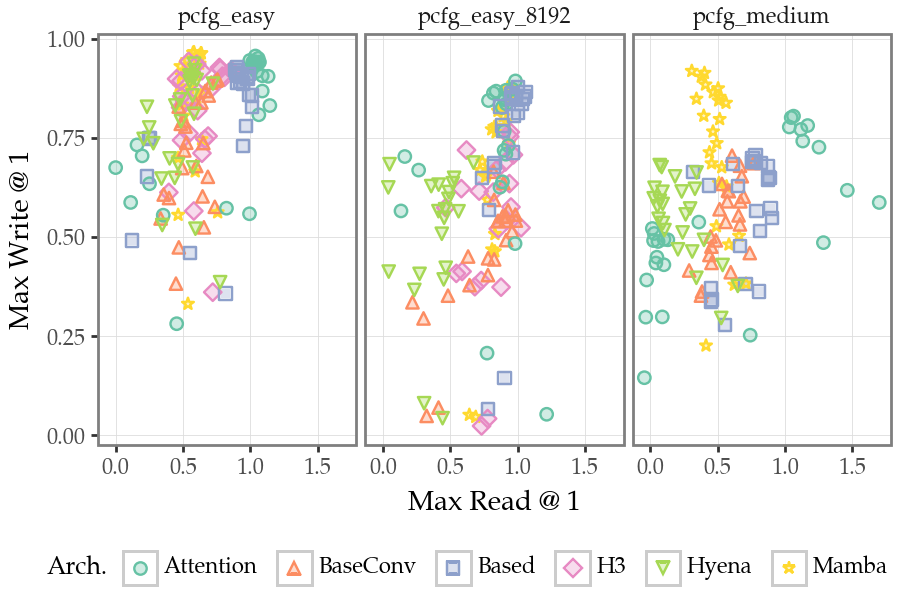

In [113]:
subset_df_int_plot = get_attrib_df(df, df_int, components=["attention_input", "attention_output", "mlp_input", "mlp_output"], prefix="PARENT")
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig, attention_input"] - subset_df_int_plot["Corrupted @ 0, target_item_orig, attention_input"]) > 0.005]

for layer in range(2):
    for label, component in {"Read": "attention_input", "Write": "attention_output"}.items():
        columns = [x for x in subset_df_int_plot.columns if x.startswith(f"Association @ {layer}") and x.endswith(component)]
        print(columns)
        subset_df_int_plot[f"{label} @ {layer}"] = subset_df_int_plot.apply(lambda row: max([row[col] for col in columns]), axis=1)
        
subset_df_int_plot["arch"] = pd.Categorical(subset_df_int_plot["arch"], categories=list(subset_df_int["arch"].unique()))
subset_df_int_plot["dim"] = pd.Categorical(subset_df_int_plot["dim"], categories=[x for x in sorted(subset_df_int_plot["dim"].unique())], ordered=True)

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Read @ 1", y="Likelihood", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(4.5, 3), legend_position="top") +
    p9.labs(color="Arch.", shape="Arch.", x="Max Read @ 1", y="Max Write @ 1") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()

# plot = (
#     p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="Association @ 0, query_item_orig, attention_output", color="arch", group="arch")) +
#     p9.facet_wrap("~dataset") +
#     # p9.geom_path(linetype="dashed") + 
#     p9.geom_boxplot() +
#     # p9.scale_x_log10() +
#     # p9.labs(color="Arch.", shape="Dim.", x="Attrib @ 1, Key", y="Attrib @ 1, Value") +
#     p9.theme(figure_size=(4.5, 3), legend_position="top")
# )
# plot.show()

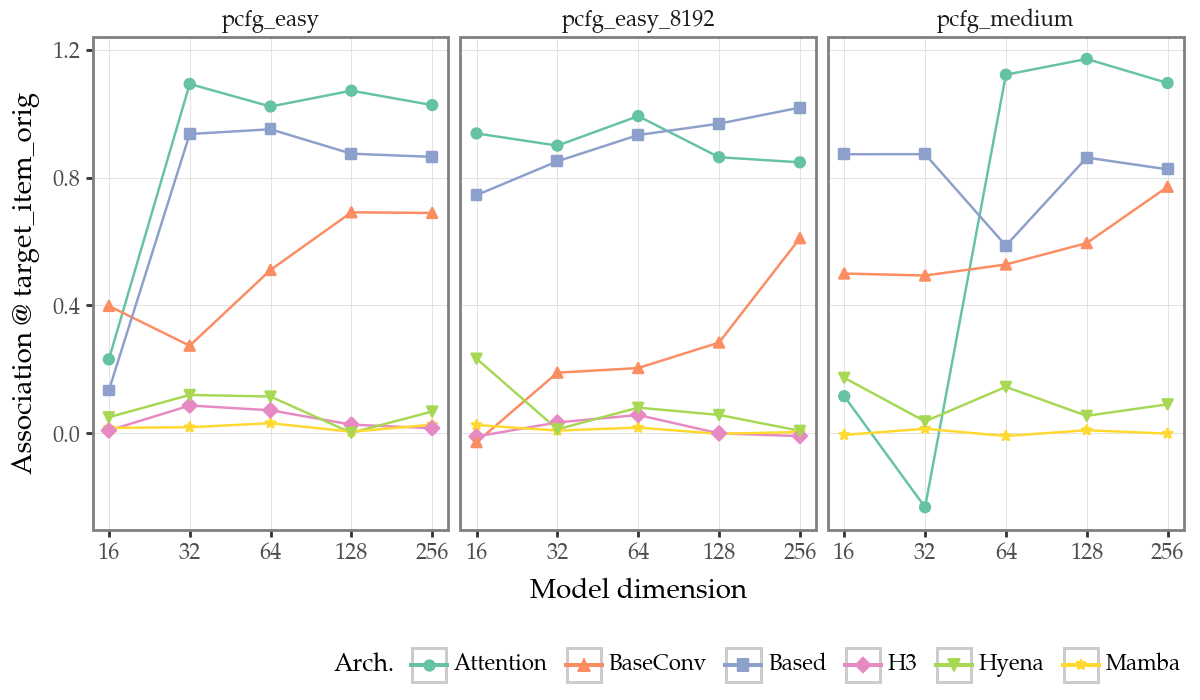

In [115]:
plot = (
    p9.ggplot(subset_df_int_best, p9.aes(x="dim", y="Association @ 1, target_item_orig", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Association @ target_item_orig", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.theme(figure_size=(6, 3.5)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()

In [125]:
[x for x in subset_df_int.columns if "Corrupted" in x]

['Corrupted @ 0, divider',
 'Corrupted @ 0, query_item',
 'Corrupted @ 0, query_item_orig',
 'Corrupted @ 0, target_item_orig']

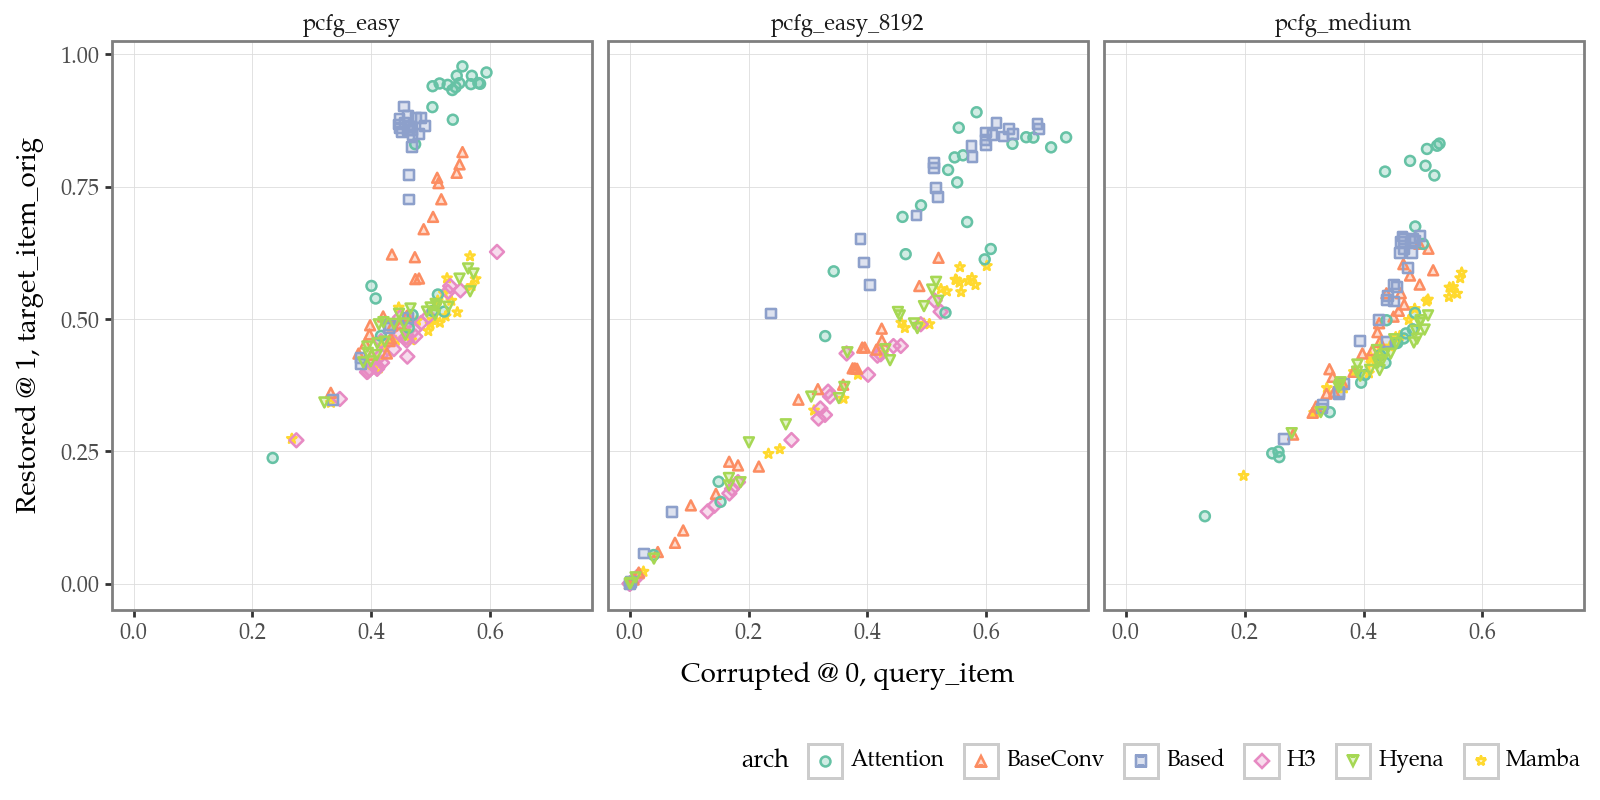

In [123]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot["dim"] = subset_df_int_plot["dim"].apply(lambda x: str(x))
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Corrupted @ 0, query_item", y="Restored @ 1, target_item_orig", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_point(alpha=0.3) + 
    p9.geom_point(fill="none", stroke=0.5) +
    p9.theme(figure_size=(8, 4)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()

## ATR layers

In [112]:
dirs = [
    "../experiments/logs/pcfg_easy/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_1L/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)

100%|██████████| 300/300 [00:35<00:00,  8.48it/s]


300


In [113]:
df["dataset"] = df["dataset"].map({
    "pcfg_easy": "2-layer",
    "pcfg_easy_nope": "2-layer",
    "pcfg_easy_1L": "1-layer",
})


In [114]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{value} \\
dataset & \multicolumn{5}{r}{1-layer} & \multicolumn{5}{r}{2-layer} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 65.62 & 69.69 & 73.75 & 71.25 & 74.69 & 68.44 & 90.31 & 93.75 & 95.31 & 96.25 \\
BaseConv & 51.25 & 51.56 & 51.56 & 51.25 & 51.56 & 67.50 & 75.62 & 82.50 & 86.88 & 90.00 \\
Based & 51.25 & 51.56 & 51.56 & 51.56 & 51.25 & 82.19 & 91.25 & 91.88 & 93.12 & 92.19 \\
H3 & 68.75 & 81.88 & 85.31 & 87.19 & 89.69 & 81.88 & 87.81 & 90.00 & 94.06 & 94.06 \\
Hyena & 70.00 & 77.50 & 82.50 & 86.56 & 89.38 & 75.94 & 80.94 & 85.31 & 92.50 & 93.75 \\
Mamba & 85.31 & 87.50 & 91.56 & 93.44 & 94.38 & 91.25 & 94.38 & 96.25 & 96.88 & 96.25 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1474591/2876777681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


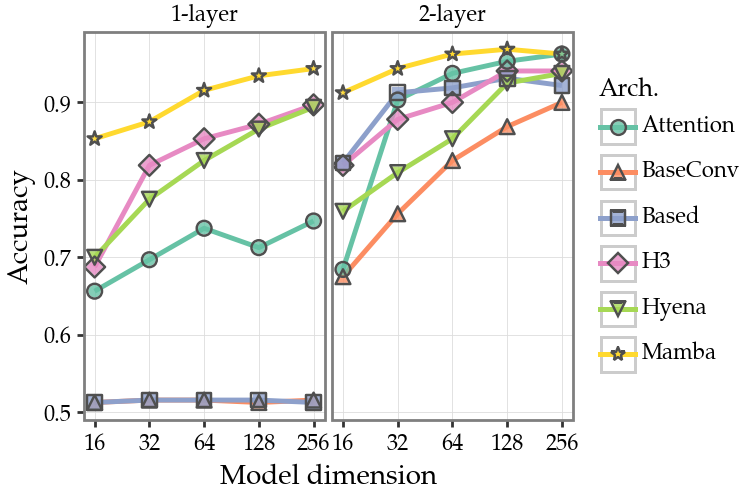

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.75 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_layers.pdf


In [118]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, stroke=0, alpha=0.8) +
    p9.geom_point(fill="none", stroke=0.5, size=2.5, color="#4f4f4f") +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    # p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(3.75, 2.5),
        legend_position="right",
    )
)

plot.show()
plot.save("figs/atr_layers.pdf", dpi=300)


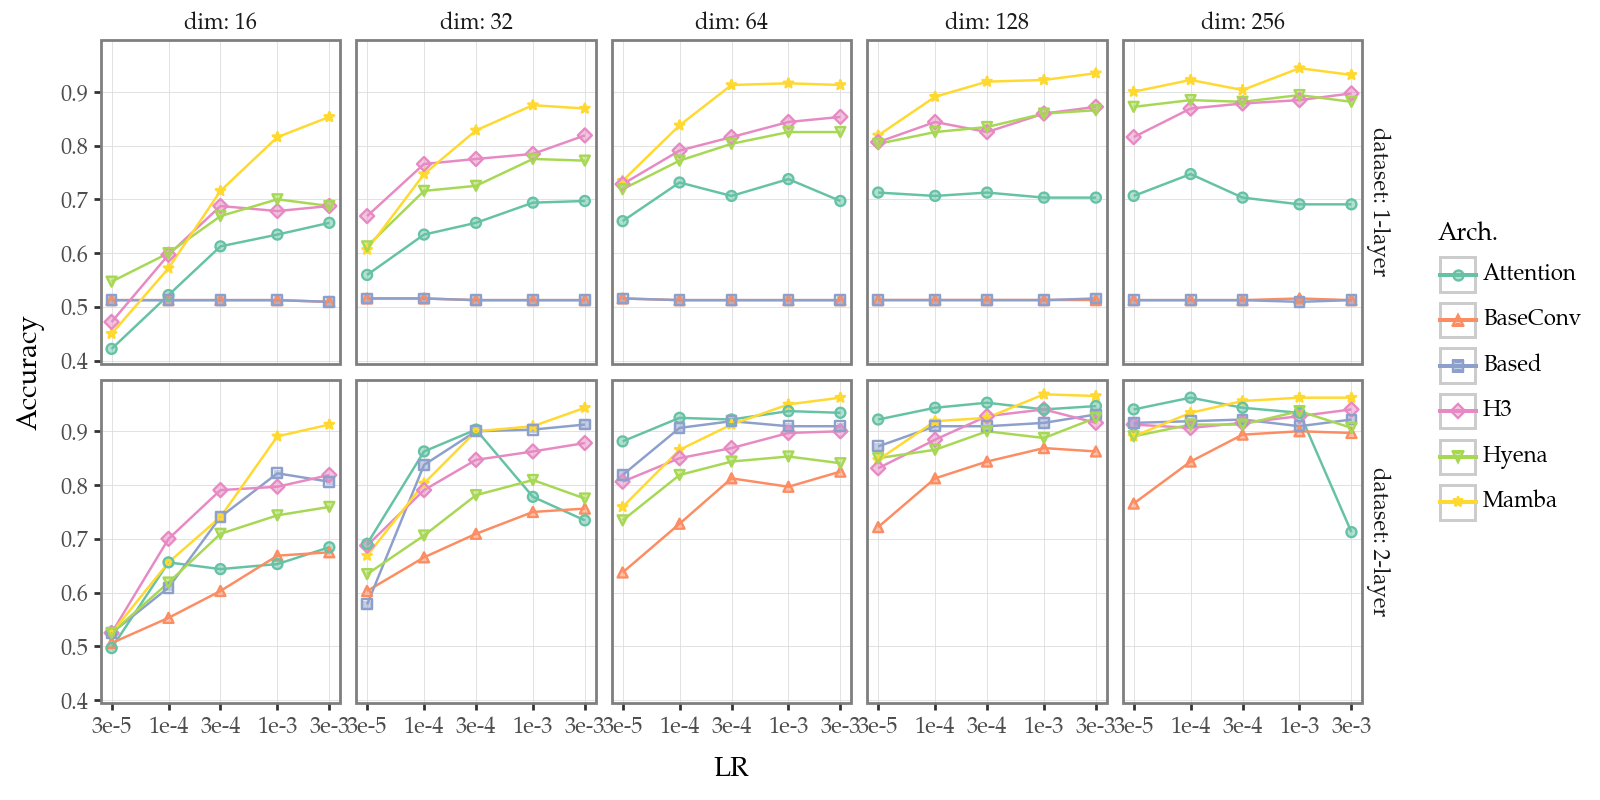

In [87]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point(stroke=0, alpha=0.5) +
    p9.geom_point(fill="none", stroke=0.5) +
    p9.facet_grid("dataset~dim", labeller="label_both") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(8, 4),
        legend_position="right",
    )
)
plot.show()

## Layer choice ATR

In [8]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_8192/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs, filter_steps=50000)

100%|██████████| 632/632 [00:54<00:00, 11.51it/s]


632


In [9]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_8192/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs, filter_steps=50000)

100%|██████████| 631/631 [01:58<00:00,  5.32it/s]


631


In [10]:
df_int["variable"] = df_int["variable"].apply(lambda x: x.replace("PARENT", "KEY"))

In [11]:
subset_df_int = get_attrib_df(df, df_int, corruption="query_item_orig", components="attention_output", prefix="KEY")
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, query_item"]]
pivoted["Association @ 1, query_item"] = pivoted["Association @ 1, query_item"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllllllllllllll}
\toprule
 & \multicolumn{25}{r}{Association @ 1, query_item} \\
dataset & \multicolumn{5}{r}{ar_32} & \multicolumn{5}{r}{ar_32_more_lr} & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_easy_8192} & \multicolumn{5}{r}{pcfg_medium} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 100.20 & 100.00 & 100.00 & 100.00 & 100.00 & 14.04 & 100.00 & 9.30 & 100.00 & nan & 60.79 & 98.87 & 99.04 & 99.11 & 99.05 & 99.82 & 100.01 & 100.02 & 100.04 & 100.30 & 0.79 & -111.77 & 99.83 & 98.91 & 98.42 \\
BaseConv & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 \\
Based & 100.00 & 100.

In [12]:
subset_df_int

dim       arch       lr         dataset split  \
0     16  Attention  0.00003           ar_32  test   
1     16  Attention  0.00003       pcfg_easy  test   
2     16  Attention  0.00003  pcfg_easy_8192  test   
3     16  Attention  0.00003     pcfg_medium  test   
4     16  Attention  0.00010           ar_32  test   
..   ...        ...      ...             ...   ...   
627  256      Mamba  0.00300       pcfg_easy  test   
628  256      Mamba  0.00300  pcfg_easy_8192  test   
629  256      Mamba  0.00300     pcfg_medium  test   
630  256      Mamba  0.01000   ar_32_more_lr  test   
631  256      Mamba  0.03000   ar_32_more_lr  test   

     0.KEY.query_item_orig.divider.attention_input.kl_div  \
0                                                  0.0      
1                                                  0.0      
2                                                  0.0      
3                                                  0.0      
4                                                  0.0      
..                                                 ...      
627                                                0.0      
628                                                0.0      
629                                                0.0      
630                                                0.0      
631                                                0.0      

     0.KEY.query_item_orig.divider.attention_input.logit_diff  \
0                                                  0.0          
1                                                  0.0          
2                                                  0.0          
3                                                  0.0          
4                                                  0.0          
..                                                 ...          
627                                                0.0          
628                                                0.0          
629                                                0.0          
630                                                0.0          
631                                                0.0          

     0.KEY.query_item_orig.divider.attention_input.max_perc  \
0                                                  0.0        
1                                                  0.0        
2                                                  0.0        
3                                                  0.0        
4                                                  0.0        
..                                                 ...        
627                                                0.0        
628                                                0.0        
629                                                0.0        
630                                                0.0        
631                                                0.0        

     0.KEY.query_item_orig.divider.attention_input.max_perc_layer  \
0                                                  0.0              
1                                                  0.0              
2                                                  0.0              
3                                                  0.0              
4                                                  0.0              
..                                                 ...              
627                                                0.0              
628                                                0.0              
629                                                0.0              
630                                                0.0              
631                                                0.0              

     0.KEY.query_item_orig.divider.attention_input.prob_diff  ...  Accuracy  \
0                                                  0.0        ...  0.000000   
1                                                  0.0        ...  0.496875   
2                  

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 133 rows containing missing values.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 133 rows containing missing values.


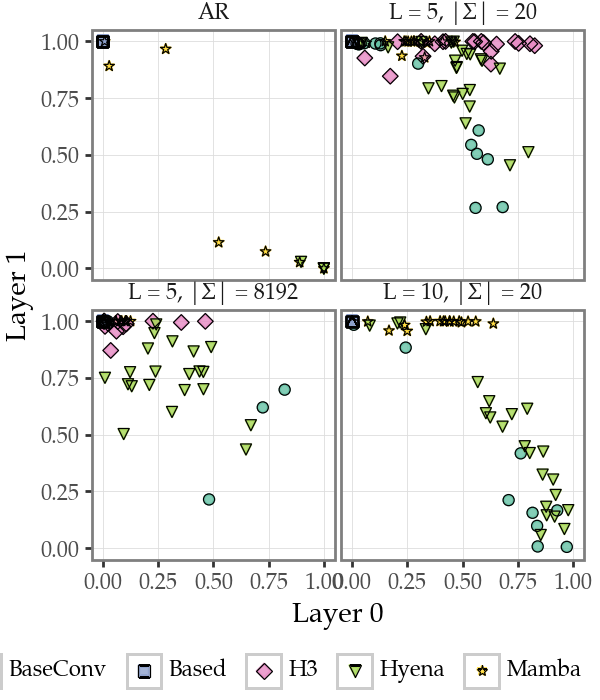

In [28]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
    "pcfg_easy": "L = 5, |Σ| = 20",
    "pcfg_easy_8192": "L = 5, |Σ| = 8192",
    "pcfg_medium": "L = 10, |Σ| = 20",
    "ar_32": "AR",
    "ar_32_nope": "AR",
    "ar_32_more_lr": "AR",
})
subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["AR", "L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)
subset_df_int_plot = subset_df_int_plot[subset_df_int_plot["Original @ 0, query_item"] - subset_df_int_plot["Corrupted @ 0, query_item"] > 0.01]

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 0, query_item", y="Association @ 1, query_item", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(alpha=0.8) +
    p9.geom_point(fill="none", stroke=0.25, color="black", size=2) +
    p9.labs(x="Layer 0", y="Layer 1", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
        figure_size=(3, 3.5)
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    ) +
    p9.xlim(0, 1) +
    p9.ylim(0, 1)
)
plot.show()


In [108]:
subset_df = df[df["step_rel"] == 1.0].copy()
subset_df["dataset"] = subset_df["dataset"].map({
    "pcfg_easy_nope": "L = 5, |Σ| = 20",
    "pcfg_easy": "L = 5, |Σ| = 20",
    "pcfg_easy_8192": "L = 5, |Σ| = 8192",
    "pcfg_medium": "L = 10, |Σ| = 20",
    "ar_32": "AR",
    "ar_32_nope": "AR",
    "ar_32_more_lr": "AR",
})
subset_df["dataset"] = pd.Categorical(subset_df["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20", "AR"], ordered=True)
subset_df = subset_df.pivot(index=["arch", "lr", "dim", "dataset"], columns="variable", values="value").reset_index()
subset_df

variable       arch       lr  dim          dataset  \
0         Attention  0.00003   16               AR   
1         Attention  0.00003   16  L = 5, |Σ| = 20   
2         Attention  0.00003   32               AR   
3         Attention  0.00003   32  L = 5, |Σ| = 20   
4         Attention  0.00003   64               AR   
..              ...      ...  ...              ...   
353           Mamba  0.03000   16               AR   
354           Mamba  0.03000   32               AR   
355           Mamba  0.03000   64               AR   
356           Mamba  0.03000  128               AR   
357           Mamba  0.03000  256               AR   

variable  0.KEY.query_item_orig.divider.attention_input.kl_div  \
0                                                       0.0      
1                                                       NaN      
2                                                       0.0      
3                                                       NaN      
4                                                       0.0      
..                                                      ...      
353                                                     0.0      
354                                                     NaN      
355                                                     NaN      
356                                                     NaN      
357                                                     0.0      

variable  0.KEY.query_item_orig.divider.attention_input.logit_diff  \
0                                                       0.0          
1                                                       NaN          
2                                                       0.0          
3                                                       NaN          
4                                                       0.0          
..                                                      ...          
353                                                     0.0          
354                                                     NaN          
355                                                     NaN          
356                                                     NaN          
357                                                     0.0          

variable  0.KEY.query_item_orig.divider.attention_input.max_perc  \
0                                                       0.0        
1                                                       NaN        
2                                                       0.0        
3                                                       NaN        
4                                                       0.0        
..                                                      ...        
353                                                     0.0        
354                                                     0.0        
355                                                     0.0        
356                                                     0.0        
357                                                     0.0        

variable  0.KEY.query_item_orig.divider.attention_input.max_perc_layer  \
0                                                       0.0              
1                                                       NaN              
2                                                       0.0              
3                                                       NaN              
4                                                       0.0              
..                                                      ...              
353                                                     0.0              
354                                                     0.0              
355                                                     0.0              
356                                                     0.0              
357                                                     0.0              

variable  0

## ATR generalisation

In [85]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/test/SummaryEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/dev/SummaryEvaluator.csv",
]
df = read_df(dirs)
df

100%|██████████| 294/294 [00:22<00:00, 13.19it/s]


294


variable    step         evaluator  step_rel  \
0      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
1      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
2      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
3      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
4      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
...                         ...     ...               ...       ...   
43213      query_item.pred_prob  100000  SummaryEvaluator       1.0   
43214      query_item.pred_prob  100000  SummaryEvaluator       1.0   
43215      query_item.pred_prob  100000  SummaryEvaluator       1.0   
43216      query_item.pred_prob  100000  SummaryEvaluator       1.0   
43217      query_item.pred_prob  100000  SummaryEvaluator       1.0   

                                              identifier       arch  dim  \
0      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
1      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
2      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
3      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
4      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
...                                                  ...        ...  ...   
43213  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   
43214  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   
43215  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   
43216  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   
43217  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   

            lr  layers  dataset split     value  
0      0.00100       2  new_gen   dev  0.003125  
1      0.00100       2  new_gen  test  0.000000  
2      0.00010       2  new_gen   dev  0.003125  
3      0.00010       2  new_gen  test  0.000000  
4      0.00300       2  new_gen   dev  0.003125  
...        ...     ...      ...   ...       ...  
43213  0.00300       2  new_gen  test  0.468829  
43214  0.00030       2  new_gen   dev  0.879024  
43215  0.00030       2  new_gen  test  0.274468  
43216  0.00003       2  new_gen   dev  0.699813  
43217  0.00003       2  new_gen  test  0.189124  

[43218 rows x 12 columns]

In [86]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df.copy().reset_index().pivot(index=["arch", "dim", "lr", "dataset"], columns="split", values="value").reset_index()
subset_df_best = subset_df_best[["dim", "arch", "dev", "test", "dataset"]]
subset_df_best = subset_df_best.iloc[subset_df_best.groupby(["dim", "arch", "dataset"])["dev"].idxmax()].reset_index()

pivoted = subset_df_best.copy()
pivoted["dev"] = pivoted["dev"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted["test"] = pivoted["test"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.melt(id_vars=["dim", "arch", "dataset", "index"])[["dim", "arch", "dataset", "split", "value"]]
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "split", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{value} \\
dataset & \multicolumn{10}{r}{new_gen} \\
split & \multicolumn{5}{r}{dev} & \multicolumn{5}{r}{test} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 86.88 & 91.25 & 95.00 & 95.94 & 95.62 & 35.00 & 53.44 & 60.00 & 68.12 & 68.12 \\
BaseConv & 74.06 & 81.25 & 84.38 & 89.38 & 91.56 & 23.75 & 16.56 & 19.69 & 24.06 & 27.19 \\
Based & 84.06 & 91.56 & 92.19 & 93.12 & 93.44 & 35.62 & 42.50 & 48.44 & 46.25 & 47.19 \\
H3 & 81.88 & 88.44 & 88.44 & 91.25 & 91.88 & 47.81 & 44.06 & 49.38 & 54.37 & 56.88 \\
Hyena & 80.00 & 82.19 & 89.06 & 92.19 & 91.56 & 24.06 & 13.44 & 34.06 & 42.81 & 45.31 \\
Mamba & 89.69 & 93.12 & 96.88 & 97.50 & 98.12 & 52.50 & 32.50 & 46.56 & 59.38 & 65.00 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1474591/3747605971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


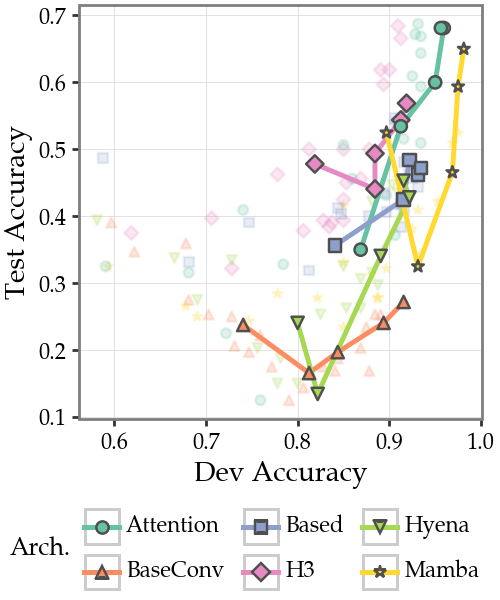

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen_dev_test.pdf


In [102]:
dev_test_combined = subset_df.copy()
dev_test_combined_best = subset_df_best.copy()
dev_test_combined = dev_test_combined.pivot(index=["arch", "dim", "dataset", "lr"], columns="split", values="value").reset_index()
# dev_test_combined_best = dev_test_combined_best.pivot(index=["arch", "dim", "dataset"], columns="split", values="value").reset_index()
plot = (
    p9.ggplot(dev_test_combined, p9.aes(x="dev", y="test", color="arch", group="arch", shape="arch")) +
    # p9.facet_wrap("~dim") +
    # p9.geom_path() +
    p9.geom_point(alpha=0.2, stroke=0.5) +
    p9.geom_path(dev_test_combined_best, size=1) +
    p9.geom_point(dev_test_combined_best, p9.aes(fill="arch"), stroke=0.5, size=2, color="#4f4f4f") +
    # p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(x="Dev Accuracy", y="Test Accuracy", color="Arch.", shape="Arch.", fill="Arch.") +
    # p9.geom_text(dev_test_combined[dev_test_combined["dim"].isin([16, 256])], p9.aes(label="dim"), size=6, nudge_y=0.03) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.scale_fill_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(2.5, 3)
    )
    # p9.xlim(0.7, 1) +
    # p9.ylim(0, 1)
)
plot.show()
plot.save("figs/atr_gen_dev_test.pdf")

In [97]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/test/SummaryEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/dev/SummaryEvaluator.csv",
]
df = read_df(dirs)
df

100%|██████████| 294/294 [00:09<00:00, 30.79it/s]


294


variable    step         evaluator  step_rel  \
0      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
1      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
2      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
3      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
4      PARENT.query_item.argmax       0  SummaryEvaluator       0.0   
...                         ...     ...               ...       ...   
43213      query_item.pred_prob  100000  SummaryEvaluator       1.0   
43214      query_item.pred_prob  100000  SummaryEvaluator       1.0   
43215      query_item.pred_prob  100000  SummaryEvaluator       1.0   
43216      query_item.pred_prob  100000  SummaryEvaluator       1.0   
43217      query_item.pred_prob  100000  SummaryEvaluator       1.0   

                                              identifier       arch  dim  \
0      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
1      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
2      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
3      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
4      /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
...                                                  ...        ...  ...   
43213  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   
43214  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   
43215  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   
43216  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   
43217  /nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...      Mamba   64   

            lr  layers  dataset split     value  
0      0.00100       2  new_gen   dev  0.003125  
1      0.00100       2  new_gen  test  0.000000  
2      0.00010       2  new_gen   dev  0.003125  
3      0.00010       2  new_gen  test  0.000000  
4      0.00300       2  new_gen   dev  0.003125  
...        ...     ...      ...   ...       ...  
43213  0.00300       2  new_gen  test  0.468829  
43214  0.00030       2  new_gen   dev  0.879024  
43215  0.00030       2  new_gen  test  0.274468  
43216  0.00003       2  new_gen   dev  0.699813  
43217  0.00003       2  new_gen  test  0.189124  

[43218 rows x 12 columns]

In [98]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df.copy().reset_index().pivot(index=["arch", "dim", "lr", "dataset"], columns="split", values="value").reset_index()
subset_df_best = subset_df_best[["dim", "arch", "dev", "test", "dataset"]]
subset_df_best = subset_df_best.iloc[subset_df_best.groupby(["dim", "arch", "dataset"])["dev"].idxmax()].reset_index()

pivoted = subset_df_best.copy()
pivoted["dev"] = pivoted["dev"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted["test"] = pivoted["test"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.melt(id_vars=["dim", "arch", "dataset", "index"])[["dim", "arch", "dataset", "split", "value"]]
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "split", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{value} \\
dataset & \multicolumn{10}{r}{new_gen} \\
split & \multicolumn{5}{r}{dev} & \multicolumn{5}{r}{test} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 86.88 & 91.25 & 95.00 & 95.94 & 95.62 & 35.00 & 53.44 & 60.00 & 68.12 & 68.12 \\
BaseConv & 74.06 & 81.25 & 84.38 & 89.38 & 91.56 & 23.75 & 16.56 & 19.69 & 24.06 & 27.19 \\
Based & 84.06 & 91.56 & 92.19 & 93.12 & 93.44 & 35.62 & 42.50 & 48.44 & 46.25 & 47.19 \\
H3 & 81.88 & 88.44 & 88.44 & 91.25 & 91.88 & 47.81 & 44.06 & 49.38 & 54.37 & 56.88 \\
Hyena & 80.00 & 82.19 & 89.06 & 92.19 & 91.56 & 24.06 & 13.44 & 34.06 & 42.81 & 45.31 \\
Mamba & 89.69 & 93.12 & 96.88 & 97.50 & 98.12 & 52.50 & 32.50 & 46.56 & 59.38 & 65.00 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1474591/3747605971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


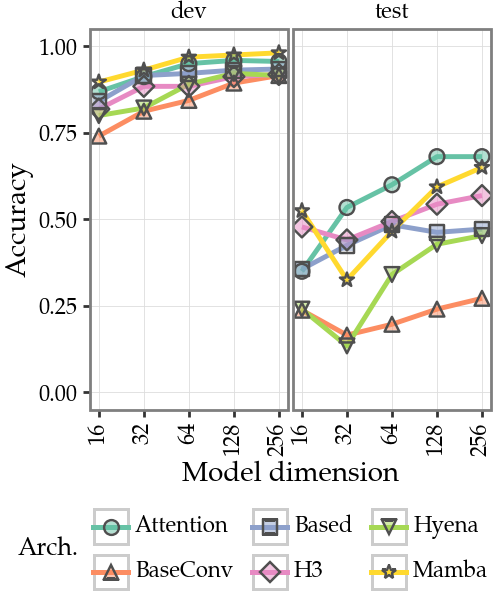

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen.pdf


In [101]:
# subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
# subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
# subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best.melt(id_vars=["dim", "arch", "dataset", "index"]), p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, stroke=0, alpha=0.5) +
    p9.geom_point(fill="none", stroke=0.5, size=2.5, color="#4f4f4f") +
    # p9.geom_text(p9.aes(label="clean")) +
    p9.facet_wrap("~split") +
    p9.ylim(0, 1) +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        axis_text_x=p9.element_text(angle=90),
        figure_size=(2.5, 3)
    )
)
plot.show()
plot.save("figs/atr_gen.pdf")

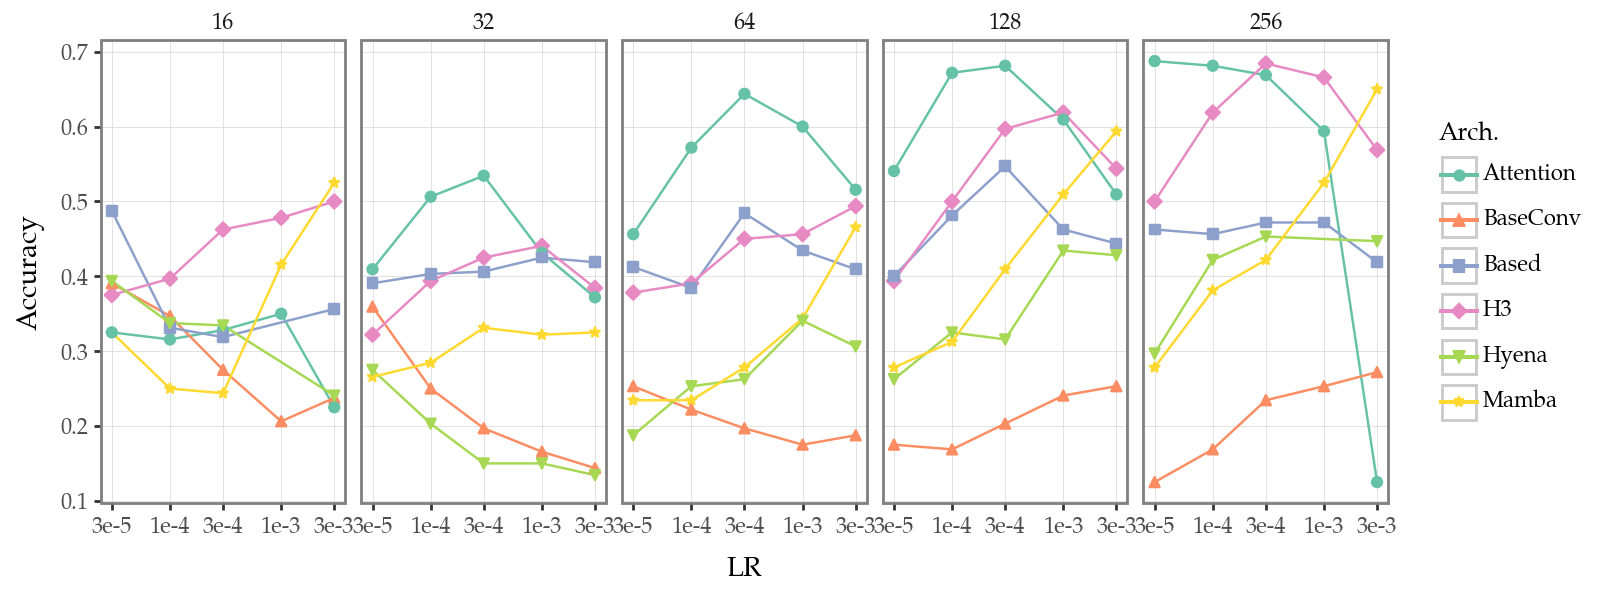

In [26]:
plot = (
    p9.ggplot(subset_df[subset_df["split"] == "test"], p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dim", nrow=1) +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.", shape="Arch.") +
    p9.theme(figure_size=(8, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="right",
    )
)
plot.show()

In [103]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/test/InterchangeEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/dev/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)
# df["arch"] = df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
# df["dataset"] = "ar_32"
df_int

100%|██████████| 294/294 [01:52<00:00,  2.61it/s]


294


variable    step  \
0        0.PARENT.query_item_orig.divider.attention_inp...       0   
1        0.PARENT.query_item_orig.divider.attention_inp...       0   
2        0.PARENT.query_item_orig.divider.attention_inp...       0   
3        0.PARENT.query_item_orig.divider.attention_inp...       0   
4        0.PARENT.query_item_orig.divider.attention_inp...       0   
...                                                    ...     ...   
6877915  original.PARENT.target_item_orig.target_item_o...  100000   
6877916  original.PARENT.target_item_orig.target_item_o...  100000   
6877917  original.PARENT.target_item_orig.target_item_o...  100000   
6877918  original.PARENT.target_item_orig.target_item_o...  100000   
6877919  original.PARENT.target_item_orig.target_item_o...  100000   

                    evaluator  step_rel  \
0        InterchangeEvaluator       0.0   
1        InterchangeEvaluator       0.0   
2        InterchangeEvaluator       0.0   
3        InterchangeEvaluator       0.0   
4        InterchangeEvaluator       0.0   
...                       ...       ...   
6877915  InterchangeEvaluator       1.0   
6877916  InterchangeEvaluator       1.0   
6877917  InterchangeEvaluator       1.0   
6877918  InterchangeEvaluator       1.0   
6877919  InterchangeEvaluator       1.0   

                                                identifier       arch  dim  \
0        /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
1        /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
2        /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
3        /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
4        /nlp/scr/rathi/tinylang_logs/new_gen/attention...  Attention  128   
...                                                    ...        ...  ...   
6877915  /nlp/scr/rathi/tinylang_logs/new_gen/hyena___6...      Hyena   64   
6877916  /nlp/scr/rathi/tinylang_logs/new_gen/hyena___6...      Hyena   64   
6877917  /nlp/scr/rathi/tinylang_logs/new_gen/hyena___6...      Hyena   64   
6877918  /nlp/scr/rathi/tinylang_logs/new_gen/hyena___6...      Hyena   64   
6877919  /nlp/scr/rathi/tinylang_logs/new_gen/hyena___6...      Hyena   64   

              lr  layers  dataset split     value  
0        0.00100       2  new_gen   dev  0.000000  
1        0.00100       2  new_gen  test  0.000000  
2        0.00010       2  new_gen   dev  0.000000  
3        0.00010       2  new_gen  test  0.000000  
4        0.00300       2  new_gen   dev  0.000000  
...          ...     ...      ...   ...       ...  
6877915  0.00300       2  new_gen  test  0.301929  
6877916  0.00030       2  new_gen   dev  0.852399  
6877917  0.00030       2  new_gen  test  0.260242  
6877918  0.00003       2  new_gen   dev  0.739645  
6877919  0.00003       2  new_gen  test  0.178998  

[6877920 rows x 12 columns]

In [104]:
subset_df_int = get_attrib_df(df, df_int, corruption="query_item_orig", components="block_input", prefix="PARENT")
subset_df_int
# subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

# pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
# pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
# pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
# print(pivoted.to_latex())

dim       arch       lr  dataset split  \
0     16  Attention  0.00003  new_gen   dev   
1     16  Attention  0.00003  new_gen  test   
2     16  Attention  0.00010  new_gen   dev   
3     16  Attention  0.00010  new_gen  test   
4     16  Attention  0.00030  new_gen   dev   
..   ...        ...      ...      ...   ...   
289  256      Mamba  0.00030  new_gen  test   
290  256      Mamba  0.00100  new_gen   dev   
291  256      Mamba  0.00100  new_gen  test   
292  256      Mamba  0.00300  new_gen   dev   
293  256      Mamba  0.00300  new_gen  test   

     0.PARENT.query_item_orig.divider.attention_input.kl_div  \
0                                                  0.0         
1                                                  0.0         
2                                                  0.0         
3                                                  0.0         
4                                                  0.0         
..                                                 ...         
289                                                0.0         
290                                                0.0         
291                                                0.0         
292                                                0.0         
293                                                0.0         

     0.PARENT.query_item_orig.divider.attention_input.logit_diff  \
0                                                  0.0             
1                                                  0.0             
2                                                  0.0             
3                                                  0.0             
4                                                  0.0             
..                                                 ...             
289                                                0.0             
290                                                0.0             
291                                                0.0             
292                                                0.0             
293                                                0.0             

     0.PARENT.query_item_orig.divider.attention_input.max_perc  \
0                                                  0.0           
1                                                  0.0           
2                                                  0.0           
3                                                  0.0           
4                                                  0.0           
..                                                 ...           
289                                                0.0           
290                                                0.0           
291                                                0.0           
292                                                0.0           
293                                                0.0           

     0.PARENT.query_item_orig.divider.attention_input.max_perc_layer  \
0                                                  0.0                 
1                                                  0.0                 
2                                                  0.0                 
3                                                  0.0                 
4                                                  0.0                 
..                                                 ...                 
289                                                0.0                 
290                                                0.0                 
291                                                0.0                 
292                                                0.0                 
293                                                0.0                 

     0.PARENT.query_item_orig.divider.attention_input.prob_diff  ...  \
0                                                  0.0           ...   
1                                                  0

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 6 rows containing non-finite values.


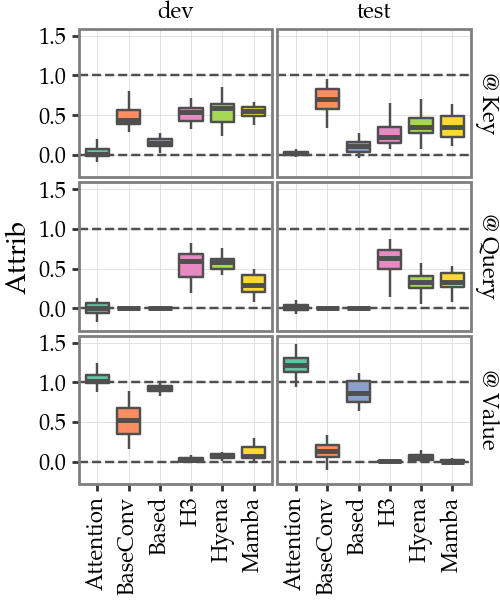

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen_box.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 6 rows containing non-finite values.


In [111]:
subset_df_int_plot = subset_df_int.copy()
# subset_df_int_plot = subset_df_int_plot[subset_df_int_plot["split"] == "test"]
# subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.1]
subset_df_int_plot = subset_df_int_plot[["dim", "arch", "dataset", "split", "Association @ 1, query_item", "Association @ 1, query_item_orig", "Association @ 1, target_item_orig"]]
subset_df_int_plot = subset_df_int_plot.melt(id_vars=["dim", "arch", "dataset", "split"])
subset_df_int_plot["variable"] = subset_df_int_plot["variable"].map({
    "Association @ 1, query_item": "@ Query",
    "Association @ 1, query_item_orig": "@ Key",
    "Association @ 1, target_item_orig": "@ Value"
})
subset_df_int_plot

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="value", fill="arch", group="arch", shape="arch")) +
    p9.facet_grid("variable ~ split", scales="free_y") +
    p9.scale_y_continuous(breaks=[0, 0.5, 1.0, 1.5, 2.0]) +
    p9.geom_hline(yintercept=1, linetype="dashed", color="#4f4f4f") +
    p9.geom_hline(yintercept=0, linetype="dashed", color="#4f4f4f") +
    p9.geom_boxplot(outlier_alpha=0, color="#4f4f4f") +
    # p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    # p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(y="Attrib") +
    p9.scale_fill_brewer(type='qual', palette='Set2') +
    p9.ylim(-0.2, 1.5) +
    p9.theme(
        legend_position="none",
        legend_justification_bottom=1,
        axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=1),
        axis_title_x=p9.element_blank(),
        figure_size=(2.5, 3),
    )
)
plot.show()
plot.save("figs/atr_gen_box.pdf")

144


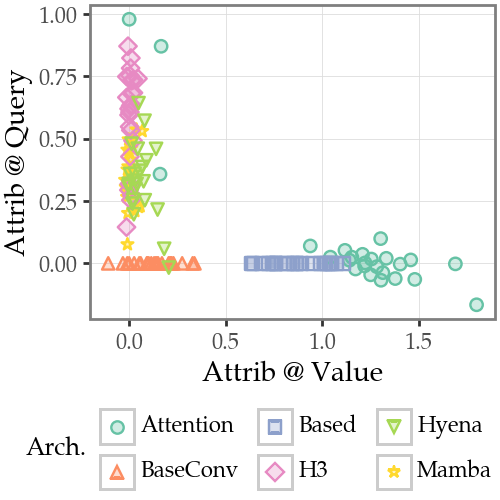

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen_diff.pdf


In [143]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.01]
print(len(subset_df_int_plot))
# subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
#     "pcfg_easy": "L = 5, |Σ| = 20",
#     "pcfg_easy_8192": "L = 5, |Σ| = 8192",
#     "pcfg_medium": "L = 10, |Σ| = 20"
# })
# subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch", shape="arch")) +
    # p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Value", y="Attrib @ Query") +
    p9.scale_color_brewer(type='qual', palette='Set2')
)
plot.show()
plot.save("figs/atr_gen_diff.pdf")

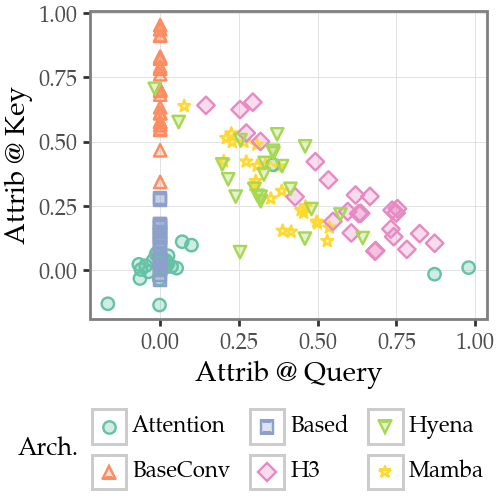

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen_diff_q.pdf


In [144]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch", shape="arch")) +
    # p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Query", y="Attrib @ Key") +
    p9.scale_color_brewer(type='qual', palette='Set2')
)
plot.show()
plot.save("figs/atr_gen_diff_q.pdf")

## Multihop

In [133]:
!ls /nlp/scr/rathi/tinylang_logs

ar_gen	   multihop    multihop_3  new_gen_1  sibling
gen_sweep  multihop_1  new_gen	   new_gen_3  sibling_3


In [134]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/multihop/**/test/SummaryEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/multihop_1/**/test/SummaryEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/multihop_3/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)

100%|██████████| 433/433 [00:31<00:00, 13.75it/s]


433


In [135]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df["dataset"] = subset_df["dataset"].map({
    "multihop": "2-layer",
    "multihop_1": "1-layer",
    "multihop_3": "3-layer",
})
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{value} \\
dataset & \multicolumn{5}{r}{1-layer} & \multicolumn{5}{r}{2-layer} & \multicolumn{5}{r}{3-layer} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 85.31 & 91.25 & 91.56 & NaN & 92.50 & 90.62 & 92.81 & 94.06 & 94.38 & 95.00 & 89.38 & 92.81 & 93.44 & 95.00 & 95.31 \\
BaseConv & 75.94 & 75.00 & 75.31 & 74.38 & 74.38 & 89.38 & 93.44 & 92.19 & 95.94 & 95.94 & 91.25 & 94.69 & 94.06 & 95.62 & 95.94 \\
Based & 75.94 & 75.00 & 75.31 & 74.38 & 74.38 & 91.88 & 92.81 & 92.81 & 93.75 & 94.38 & 91.56 & 91.56 & 94.06 & 94.38 & 95.31 \\
H3 & 88.75 & 92.81 & 95.94 & 93.12 & 96.56 & 91.88 & 93.44 & 93.75 & 96.88 & 97.50 & 92.50 & 93.12 & 95.31 & 95.31 & 97.19 \\
Hyena & 88.75 & 91.56 & 93.12 & 94.06 & 93.75 & 93.75 & 93.75 & 93.44 & 95.62 & 96.56 & 93.12 & 93.12 & 94.06 & 95.94 & 98.12 \\
Mamba & 87.19 & 94.38 & 95

/tmp/user/23259/ipykernel_1553253/873500170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/user/23259/ipykernel_1553253/873500170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


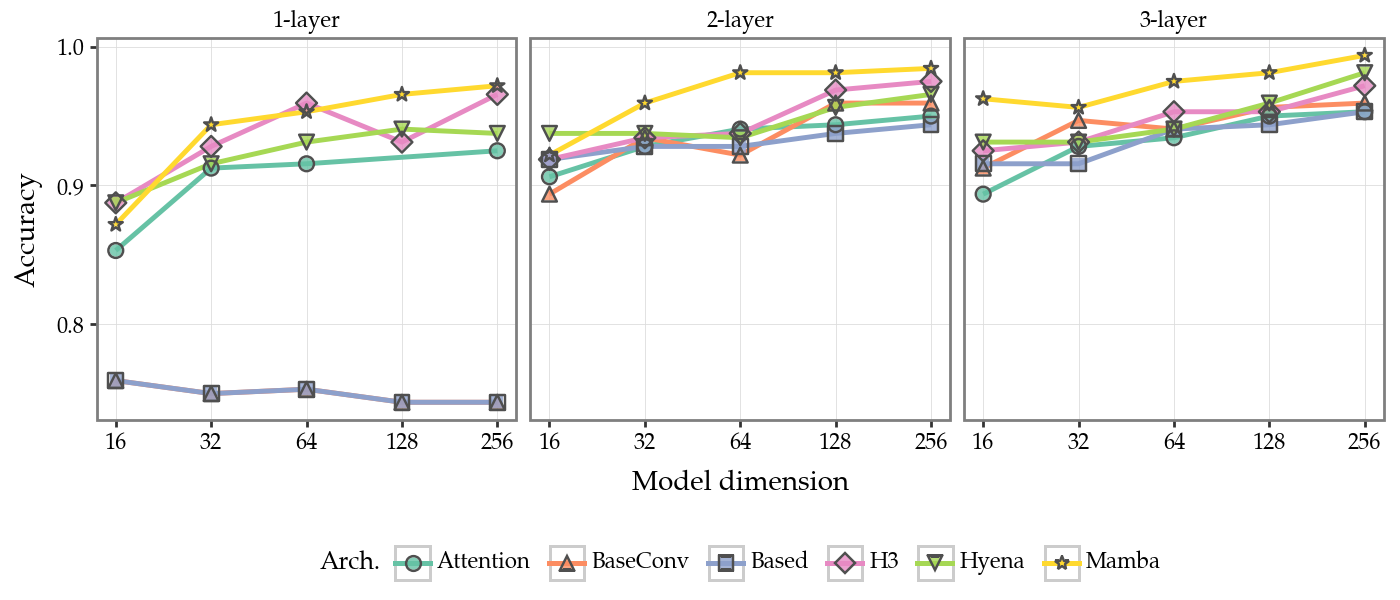

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/multihop.pdf


In [142]:
# subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
# subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, stroke=0, alpha=0.8) +
    p9.geom_point(fill="none", stroke=0.5, size=2.5, color="#4f4f4f") +
    # p9.geom_text(p9.aes(label="clean")) +
    p9.facet_wrap("~dataset") +
    # p9.ylim(0, 1.05) +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(7, 3),
        legend_justification_bottom=0.5,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/multihop.pdf", dpi=300)

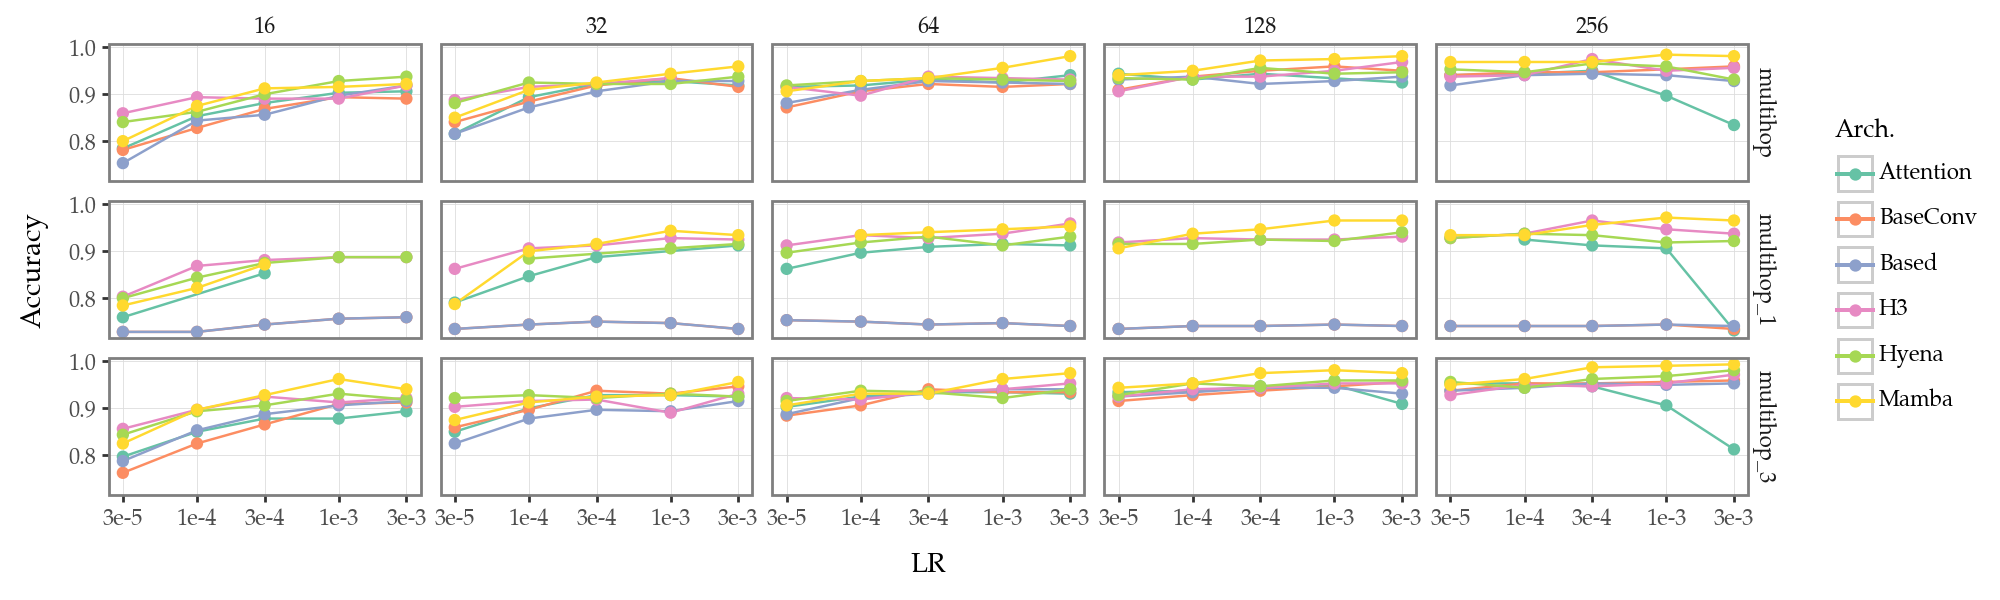

In [52]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_grid("dataset~dim") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.") +
    p9.theme(figure_size=(10, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="right",
    )
)
plot.show()

In [68]:
!ls /nlp/scr/rathi/tinylang_logs/multihop_3/attention___128___1e-03/test/

SummaryEvaluator.csv


In [59]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/multihop/**/test/InterchangeEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/multihop_1/**/test/InterchangeEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/multihop_3/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)
df_int

100%|██████████| 309/309 [01:08<00:00,  4.52it/s]


309


variable    step  \
0        0.SIBLING.query_item_orig.divider.attention_in...       0   
1        0.SIBLING.query_item_orig.divider.attention_in...       0   
2        0.SIBLING.query_item_orig.divider.attention_in...       0   
3        0.SIBLING.query_item_orig.divider.attention_in...       0   
4        0.SIBLING.query_item_orig.divider.attention_in...       0   
...                                                    ...     ...   
5968615  original.SIBLING.target_item_orig.target_item_...  100000   
5968616  original.SIBLING.target_item_orig.target_item_...  100000   
5968617  original.SIBLING.target_item_orig.target_item_...  100000   
5968618  original.SIBLING.target_item_orig.target_item_...  100000   
5968619  original.SIBLING.target_item_orig.target_item_...  100000   

                    evaluator  step_rel  \
0        InterchangeEvaluator       0.0   
1        InterchangeEvaluator       0.0   
2        InterchangeEvaluator       0.0   
3        InterchangeEvaluator       0.0   
4        InterchangeEvaluator       0.0   
...                       ...       ...   
5968615  InterchangeEvaluator       1.0   
5968616  InterchangeEvaluator       1.0   
5968617  InterchangeEvaluator       1.0   
5968618  InterchangeEvaluator       1.0   
5968619  InterchangeEvaluator       1.0   

                                                identifier       arch  dim  \
0        /nlp/scr/rathi/tinylang_logs/multihop/attentio...  Attention  128   
1        /nlp/scr/rathi/tinylang_logs/multihop/attentio...  Attention  128   
2        /nlp/scr/rathi/tinylang_logs/multihop/attentio...  Attention  128   
3        /nlp/scr/rathi/tinylang_logs/multihop/attentio...  Attention  128   
4        /nlp/scr/rathi/tinylang_logs/multihop/attentio...  Attention   16   
...                                                    ...        ...  ...   
5968615  /nlp/scr/rathi/tinylang_logs/multihop_1/hyena_...      Hyena   64   
5968616  /nlp/scr/rathi/tinylang_logs/multihop_1/hyena_...      Hyena   64   
5968617  /nlp/scr/rathi/tinylang_logs/multihop_1/hyena_...      Hyena   64   
5968618  /nlp/scr/rathi/tinylang_logs/multihop_1/hyena_...      Hyena   64   
5968619  /nlp/scr/rathi/tinylang_logs/multihop_3/h3___2...         H3  256   

              lr  layers     dataset split     value  
0        0.00010       2    multihop  test  0.000000  
1        0.00300       2    multihop  test  0.000000  
2        0.00030       2    multihop  test  0.000000  
3        0.00003       2    multihop  test  0.000000  
4        0.00100       2    multihop  test  0.000000  
...          ...     ...         ...   ...       ...  
5968615  0.00010       2  multihop_1  test  0.896329  
5968616  0.00300       2  multihop_1  test  0.915587  
5968617  0.00030       2  multihop_1  test  0.909041  
5968618  0.00003       2  multihop_1  test  0.841313  
5968619  0.00003       2  multihop_3  test  0.927220  

[5968620 rows x 12 columns]

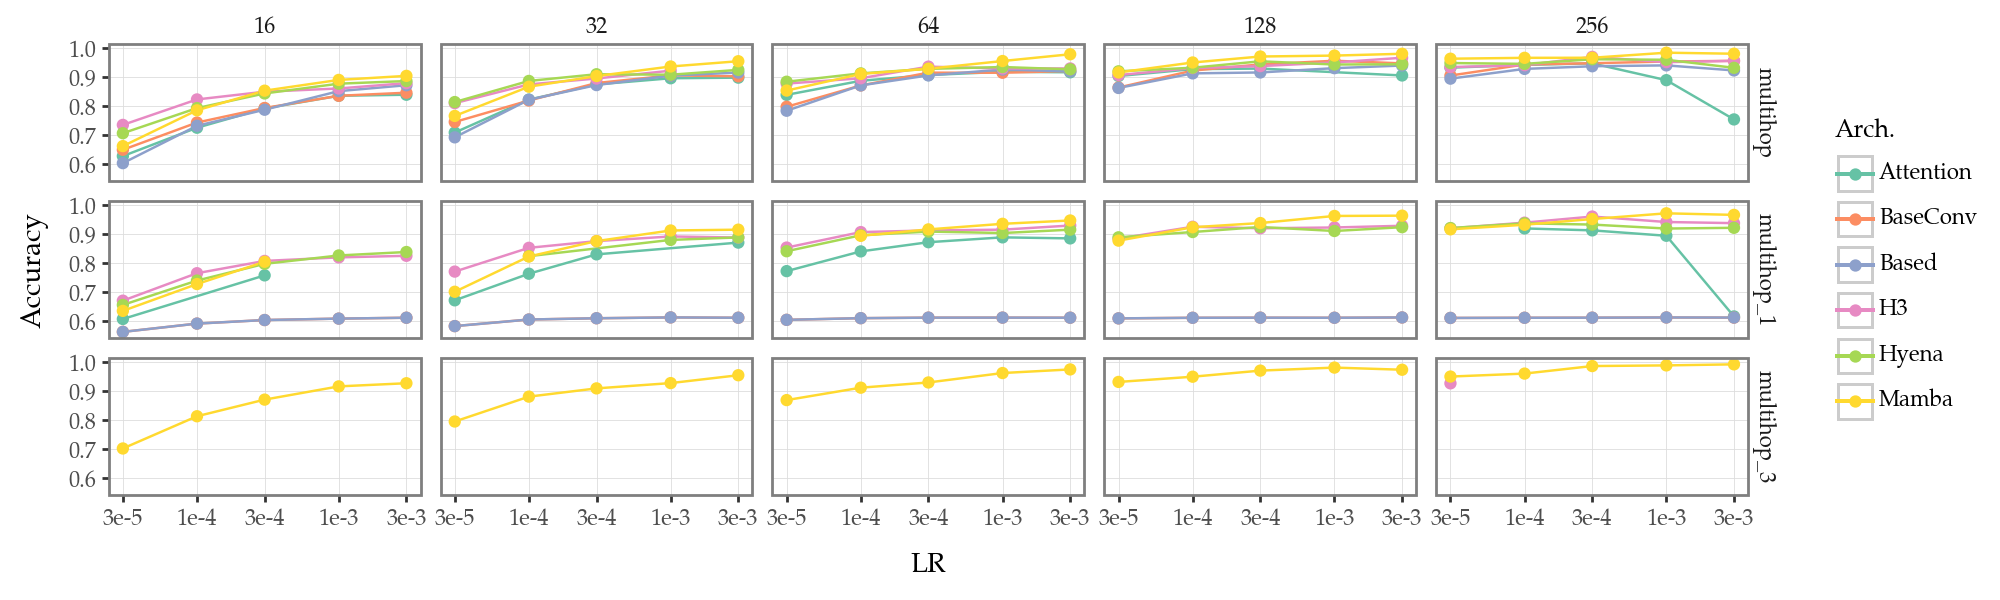

In [64]:
plot = (
    p9.ggplot(df_int[(df_int["variable"] == "original.SIBLING.target_item_orig.target_item_orig.block_input.restored_prob") & (df_int["step_rel"] == 1.0)], p9.aes(x="lr", y="value", color="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_grid("dataset~dim") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.") +
    p9.theme(figure_size=(10, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="right",
    )
)
plot.show()

In [40]:
subset_df_int = get_attrib_df(df, df_int, corruption="query_item_orig", components="block_input", prefix="SIBLING")
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{multihop} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 44.97 & 102.62 & 12.63 & 97.90 & 31.23 \\
BaseConv & 44.50 & 42.04 & 43.91 & 38.51 & 38.17 \\
Based & 49.99 & 55.99 & 62.89 & 61.08 & 60.52 \\
H3 & 37.89 & 48.12 & 34.33 & 37.52 & 29.77 \\
Hyena & 49.51 & 60.65 & 44.36 & 42.99 & 23.88 \\
Mamba & 36.43 & 42.29 & 61.45 & 53.33 & 63.00 \\
\bottomrule
\end{tabular}



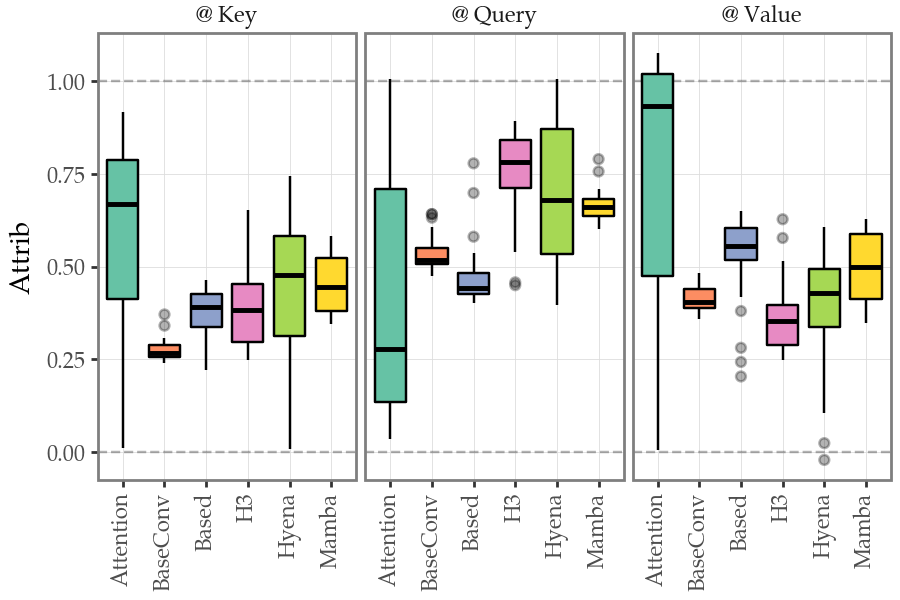

In [44]:
subset_df_int_plot = subset_df_int.copy()
# subset_df_int_plot = subset_df_int_plot[subset_df_int_plot["split"] == "test"]
# subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.1]
subset_df_int_plot = subset_df_int_plot[["dim", "arch", "dataset", "split", "Association @ 1, query_item", "Association @ 1, query_item_orig", "Association @ 1, target_item_orig"]]
subset_df_int_plot = subset_df_int_plot.melt(id_vars=["dim", "arch", "dataset", "split"])
subset_df_int_plot["variable"] = subset_df_int_plot["variable"].map({
    "Association @ 1, query_item": "@ Query",
    "Association @ 1, query_item_orig": "@ Key",
    "Association @ 1, target_item_orig": "@ Value"
})
subset_df_int_plot

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="value", fill="arch", group="arch", shape="arch")) +
    p9.facet_grid("~variable", scales="free_y") +
    p9.scale_y_continuous(breaks=[0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]) +
    p9.geom_hline(yintercept=1, linetype="dashed", alpha=0.3) +
    p9.geom_hline(yintercept=0, linetype="dashed", alpha=0.3) +
    p9.geom_boxplot(outlier_alpha=0.3, color="black") +
    # p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    # p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(y="Attrib") +
    p9.scale_fill_brewer(type='qual', palette='Set2') +
    # p9.ylim(-0.5, 1.75) +
    p9.theme(
        legend_position="none",
        legend_justification_bottom=1,
        axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=1),
        axis_title_x=p9.element_blank(),
        figure_size=(4.5, 3)
    )
)
plot.show()
# plot.save("figs/atr_gen_box.pdf")

## Mamba

In [126]:
dirs = [
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_mamba_ablation/**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_nope/mamba**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_more_lr/mamba**/test/SummaryEvaluator.csv",

]
df = read_df(dirs)
df["arch"] = df["arch"].map({
    "mamba_0": 0,
    "mamba_1": 1,
    "mamba_2": 2,
    "mamba_3": 3,
    "Mamba": 4,
})
df["arch"] = pd.Categorical(df["arch"], categories=[0, 1, 2, 3, 4], ordered=True)
df["dataset"] = "ar_32"

100%|██████████| 172/172 [00:04<00:00, 40.05it/s]

172


In [127]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
0 & 0.94 & 3.75 & 2.81 & 3.75 & 5.62 \\
1 & 0.94 & 3.12 & 2.19 & 2.81 & 2.81 \\
2 & 4.38 & 18.75 & 90.94 & 39.06 & 94.38 \\
3 & 11.88 & 70.94 & 90.94 & 94.06 & 92.19 \\
4 & 10.00 & 76.88 & 80.62 & 89.69 & 91.25 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1474591/1062887037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


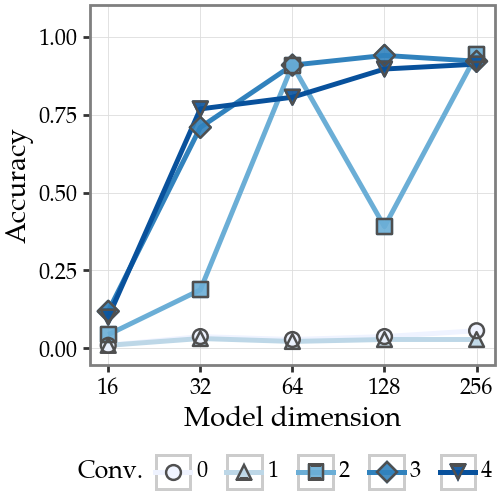

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/mamba_ar_32.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [129]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, color="#4f4f4f", size=2.5) +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Conv.", shape="Conv.") +
    p9.scale_color_brewer(type='seq', palette='Blues') +
    p9.theme(
        figure_size=(2.5, 2.5),
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)

plot.show()
plot.save("figs/mamba_ar_32.pdf", dpi=300)

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


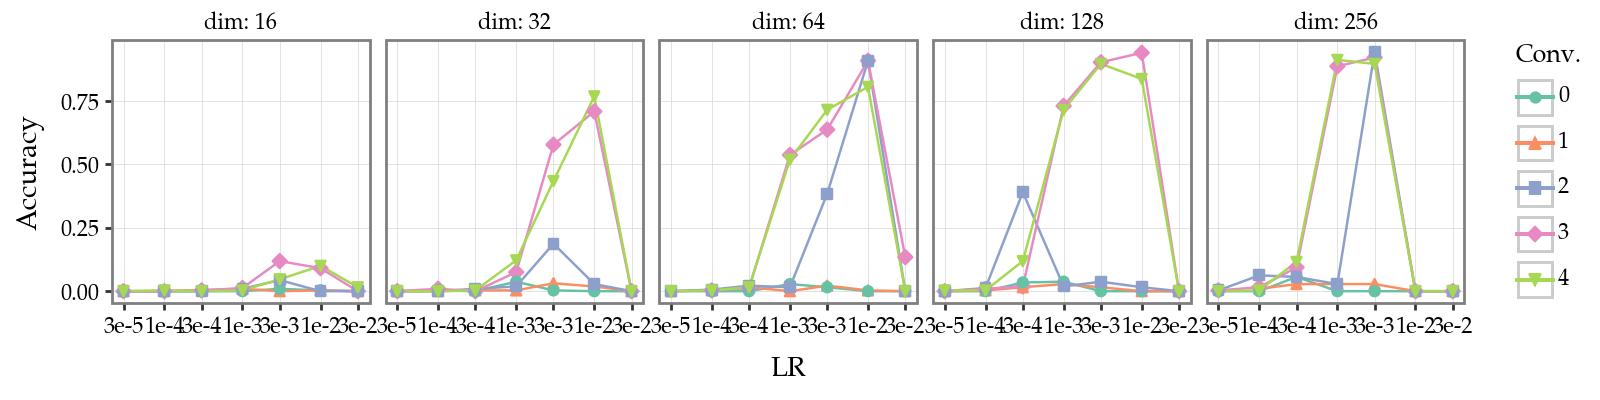

In [130]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_grid("~dim", labeller="label_both") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Conv.", shape="Conv.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(8, 2),
        legend_position="right",
    )
)
plot.show()

In [131]:
dirs = [
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_mamba_ablation/**/test/InterchangeEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_nope/mamba**/test/InterchangeEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_more_lr/mamba**/test/InterchangeEvaluator.csv",

]
df_int = read_df(dirs)
df_int["arch"] = df_int["arch"].map({
    "mamba_0": 0,
    "mamba_1": 1,
    "mamba_2": 2,
    "mamba_3": 3,
    "Mamba": 4,
})
df_int["arch"] = pd.Categorical(df_int["arch"], categories=[0, 1, 2, 3, 4], ordered=True)
df_int["dataset"] = "ar_32"

100%|██████████| 173/173 [00:35<00:00,  4.90it/s]


173


In [132]:
subset_df_int = get_attrib_df(df, df_int)
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
0 & -2.31 & 110.23 & -0.18 & -12.70 & 154.13 \\
1 & 0.03 & 106.54 & -10.50 & 96.98 & 179.03 \\
2 & 3.36 & 0.83 & 0.00 & 2.91 & -0.00 \\
3 & 0.14 & -0.01 & -0.00 & 0.00 & -0.00 \\
4 & -0.02 & 0.02 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1474591/3967278718.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


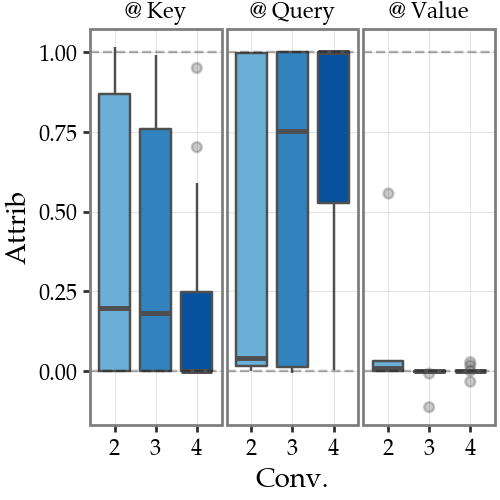

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/mamba_ar_box.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [144]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.01]
subset_df_int_plot = subset_df_int_plot[["dim", "arch", "dataset", "Association @ 1, query_item", "Association @ 1, query_item_orig", "Association @ 1, target_item_orig"]]
subset_df_int_plot = subset_df_int_plot.melt(id_vars=["dim", "arch", "dataset"])
subset_df_int_plot["variable"] = subset_df_int_plot["variable"].map({
    "Association @ 1, query_item": "@ Query",
    "Association @ 1, query_item_orig": "@ Key",
    "Association @ 1, target_item_orig": "@ Value"
})

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="value", fill="arch", group="arch", shape="arch", outlier_color="arch")) +
    p9.facet_grid("~variable", scales="free_y") +
    p9.scale_y_continuous(breaks=[-0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25]) +
    p9.geom_boxplot(outlier_alpha=0.3, color="#4f4f4f") +
    # p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    # p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(x="Conv.", y="Attrib") +
    p9.theme(figure_size=(2.5, 2.5)) +
    p9.scale_fill_brewer(type='seq', palette='Blues') +
    p9.theme(
        legend_position="none",
        legend_justification_bottom=1,
        # axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=1)
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    ) +
    p9.geom_hline(yintercept=1, linetype="dashed", alpha=0.3) +
    p9.geom_hline(yintercept=0, linetype="dashed", alpha=0.3)
)
plot.show()
subset_df_int_plot.isna().sum()
plot.save("figs/mamba_ar_box.pdf")

In [14]:
dirs = [
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_based_ablation/base**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_based_ablation2/base**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_nope/base**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_more_lr/base**/test/SummaryEvaluator.csv",

]
df = read_df(dirs)
df["arch"] = df["arch"].map({
    "Based": "3",
    "based_long_only": "long",
    "BaseConv": "BaseConv",
    "base_conv_long_only": "BaseConv (long)",
    "based_1": "1",
    "based_2": "2",
    "based_4": "4",
})
df = df[~df["arch"].str.contains("BaseConv")]
df["arch"] = pd.Categorical(df["arch"], categories=["1", "2", "3", "4", "long"], ordered=True)
df["dataset"] = "ar_32"

100%|██████████| 195/195 [00:03<00:00, 51.25it/s]


195


In [15]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
1 & 0.94 & 2.81 & 3.44 & 3.75 & 6.25 \\
2 & 18.75 & 94.69 & 98.75 & 98.75 & 98.44 \\
3 & 24.38 & 93.12 & 99.06 & 98.75 & 99.06 \\
4 & 28.44 & 85.62 & 97.19 & 97.50 & 98.12 \\
long & 0.31 & 1.56 & 3.75 & 5.94 & 9.06 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1530035/1062887037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


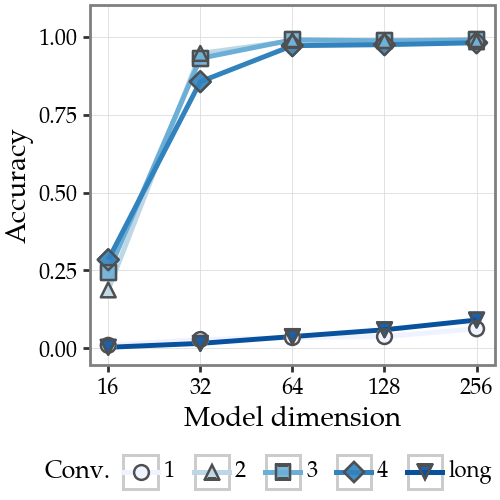

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/based_ar_32.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [21]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, color="#4f4f4f", size=2.5) +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Conv.", shape="Conv.") +
    p9.scale_color_brewer(type='seq', palette='Blues') +
    p9.theme(
        figure_size=(2.5, 2.5),
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)

plot.show()
plot.save("figs/based_ar_32.pdf", dpi=300)

## Pos emebed effect

In [38]:
dirs = [
    "../experiments/logs/pcfg_easy/**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium/**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32/**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)

100%|██████████| 847/847 [01:46<00:00,  7.97it/s]


847


In [39]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["split"] = subset_df.apply(lambda row: "NoPE" if "_nope" in row["dataset"] else "PE", axis=1)
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df = subset_df[["dim", "arch", "value", "dataset", "split"]].groupby(["dim", "arch", "dataset", "split"]).max().reset_index()

pivoted = subset_df.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["split", "dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllllllllllllllllllllllll}
\toprule
 & \multicolumn{30}{r}{value} \\
split & \multicolumn{15}{r}{NoPE} & \multicolumn{15}{r}{PE} \\
dataset & \multicolumn{5}{r}{ar_32} & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_medium} & \multicolumn{5}{r}{ar_32} & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_medium} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 4.38 & 7.19 & 9.06 & 5.94 & 5.62 & 80.94 & 87.50 & 90.00 & 92.19 & 91.56 & 55.62 & 63.12 & 69.38 & 73.75 & 73.44 & 6.56 & 100.00 & 100.00 & 100.00 & 100.00 & 68.44 & 90.31 & 93.75 & 95.31 & 96.25 & 50.94 & 56.88 & 75.62 & 80.62 & 80.94 \\
BaseConv & 0.00 & 0.94 & 3.12 & 6.56 & 9.69 & 67.50 & 75.62 & 82.50 & 86.88 & 90.00 & 55.94 & 61.56 & 65.31 & 70.62 & 68

/tmp/user/23259/ipykernel_1553253/1573005642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/user/23259/ipykernel_1553253/1573005642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


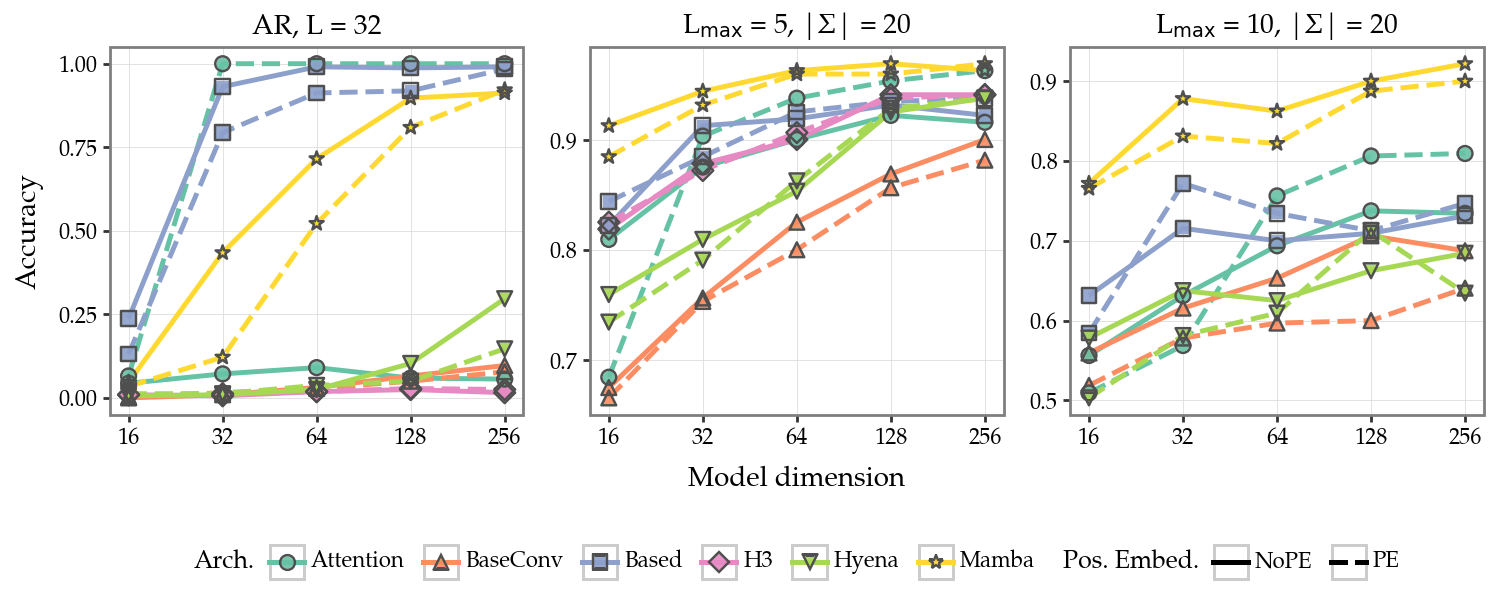

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/pos_embed.pdf


In [50]:
subset_df_plot = subset_df.copy()
subset_df_plot["dataset"] = subset_df_plot["dataset"].map({
    "ar_32": "AR, L = 32",
    "pcfg_easy": "L$_\mathrm{max}$ = 5, |Σ| = 20",
    "pcfg_easy_8192": "L$_\mathrm{max}$ = 5, |Σ| = 8192",
    "pcfg_medium": "L$_\mathrm{max}$ = 10, |Σ| = 20"
})
subset_df_plot["dataset"] = pd.Categorical(subset_df_plot["dataset"], categories=["AR, L = 32", "L$_\mathrm{max}$ = 5, |Σ| = 20", "L$_\mathrm{max}$ = 5, |Σ| = 8192", "L$_\mathrm{max}$ = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_plot, p9.aes(x="dim", y="value", color="arch", shape="arch", linetype="split")) +
    p9.geom_line(size=1) +
    p9.geom_point(stroke=0, size=2.5, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=2.5, color="#4f4f4f") +
    p9.facet_wrap("~dataset", scales="free_y") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    # p9.ylim(0, 1.05) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.", linetype="Pos. Embed.") +
    p9.theme(figure_size=(7.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=0.5,
        strip_text_x=p9.element_text(size=10),
        axis_title=p9.element_text(size=10),
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/pos_embed.pdf", dpi=300)

In [40]:
diff_df = subset_df.pivot(index=["dim", "arch", "dataset"], columns="split", values="value").reset_index()
diff_df["Diff."] = diff_df["PE"] - diff_df["NoPE"]
diff_df

split  dim       arch      dataset      NoPE        PE     Diff.
0       16  Attention        ar_32  0.043750  0.065625  0.021875
1       16  Attention    pcfg_easy  0.809375  0.684375 -0.125000
2       16  Attention  pcfg_medium  0.556250  0.509375 -0.046875
3       16   BaseConv        ar_32  0.000000  0.003125  0.003125
4       16   BaseConv    pcfg_easy  0.675000  0.665625 -0.009375
..     ...        ...          ...       ...       ...       ...
80     256      Hyena    pcfg_easy  0.937500  0.937500  0.000000
81     256      Hyena  pcfg_medium  0.684375  0.634375 -0.050000
82     256      Mamba        ar_32  0.912500  0.921875  0.009375
83     256      Mamba    pcfg_easy  0.962500  0.968750  0.006250
84     256      Mamba  pcfg_medium  0.921875  0.900000 -0.021875

[85 rows x 6 columns]

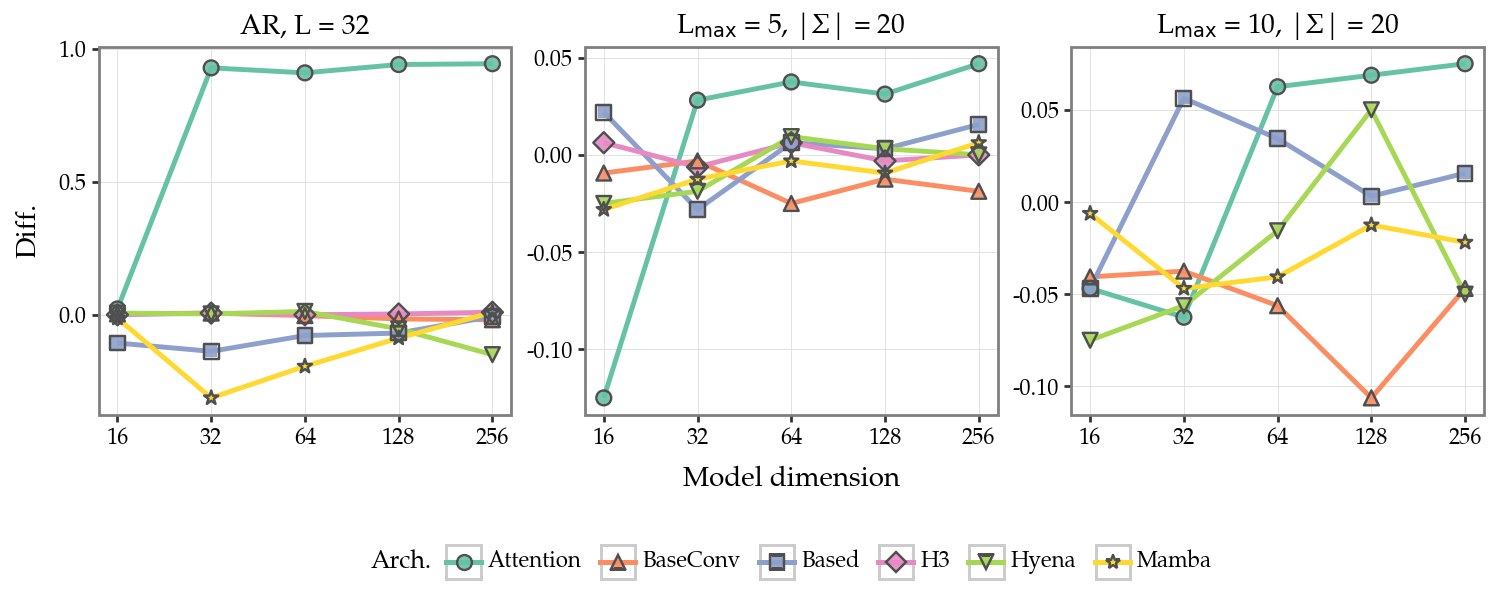

In [47]:
subset_df_plot = diff_df.copy()
subset_df_plot["dataset"] = subset_df_plot["dataset"].map({
    "ar_32": "AR, L = 32",
    "pcfg_easy": "L$_\mathrm{max}$ = 5, |Σ| = 20",
    "pcfg_easy_8192": "L$_\mathrm{max}$ = 5, |Σ| = 8192",
    "pcfg_medium": "L$_\mathrm{max}$ = 10, |Σ| = 20"
})
subset_df_plot["dataset"] = pd.Categorical(subset_df_plot["dataset"], categories=["AR, L = 32", "L$_\mathrm{max}$ = 5, |Σ| = 20", "L$_\mathrm{max}$ = 5, |Σ| = 8192", "L$_\mathrm{max}$ = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_plot, p9.aes(x="dim", y="Diff.", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(stroke=0, size=2.5, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=2.5, color="#4f4f4f") +
    p9.facet_wrap("~dataset", scales="free_y") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    # p9.ylim(0, 1.05) +
    p9.labs(y="Diff.", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.theme(figure_size=(7.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=0.5,
        strip_text_x=p9.element_text(size=10),
        axis_title=p9.element_text(size=10),
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()

## Footer